# Laboratorium 4.
Ernest Szlamczyk
## Symulowane wyżarzanie 

Laboratorium to ma na celu zbadanie metody **Symulowanego wyżarzania** w przypadkach praktycznych.

## Definicja

**Symulowane wyżarzanie** - rodzaj algorytmu heurystycznego przeszukującego przestrzeń rozwiązań w celu wyszukiwania najlepszych.<sup>[1]</sup> Zastosowane tutaj będzie w celu znajdowania minimów przykładowych funkcji. Celem algorytmu nie jest poszukiwanie globalnego minima, a jego jaknajlepszego przybliżenia (wartości).

<hr>

## Biblioteki używane podczas obecnego laboratorium:

In [45]:
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import math
import random
from PIL import Image
import numpy as np
from copy import deepcopy

## Informacje wstępne

Jako w celu optymalizacji czasu trwania poszczególnych zadań, postanowiłem robić wszystko *in situ*, dodatkowo wyliczając tylko część, która się zmienia (zmiejszając czas z rzędu O(n) lub O($n^2$) na O(1))
<hr>
W celu czytelności kodu została użyta 1 funkcja wyznaczania prawdopodobieństwa:

$$e^{\dfrac{-EnergyDifference}{Heat}}$$

Wizualizując tą funkcje, otrzymujemy:

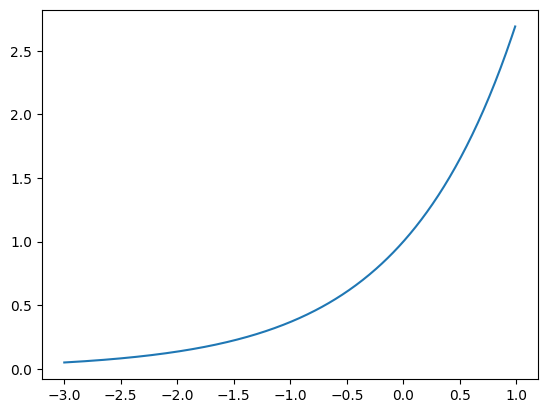

In [9]:
def f():
    Y = [math.e**(x/100) for x in range(-300,100,1)]
    X = [x/100 for x in range(-300,100)]
    plt.figure()
    plt.plot(X,Y)
f()

Jak widać, użycie tej funkcji daje nam wartość większą niż 1 dla dodatnich wartości (więc po odwróceniu, ujemna różnica energi zawsze będzie preferowana) natomiast funkcja dla wartości ujemnych przyjmuje coraz to mniejsze wartości dla coraz to mniejszych wartości argumentu

To z połączeniem z dzieleniem przez ciepło daje nam:
- dla relatywnie dużego ciepła liczba jest bliska zeru, awięc szansa jest bliska jednemu,
- dla małego ciepła - dzielimy przez małą liczbe, do da nam wyniki dalekie od zera, więc prawodopodobieństwo wybrania też będzie małe
<hr>

Pomysł ten zapisany w pythonie wygląda mniej więcej tak

In [10]:
def calcAccteptancePropability(EnergyDiff,Heat):
    if (EnergyDiff < 0):
        return 1 #so i don't destroy my ram with e^1000
    return math.exp(-EnergyDiff/Heat)

## Zadanie pierwsze - TSP

### Generowanie chmury punktów
chmure punktów generuje poprzez przekazanie różnych parametrów, a następnie używając postaci parametrycznej równania koła generuje losowo punkty w kwadratowych przestrzeniach na kole. Pudełka te są równo oddalone od siebie

In [11]:
def generate_points(n,bottom_left:tuple[float,float],upper_right:tuple[float,float]):
    x1,y1 = bottom_left
    x2,y2 = upper_right
    x_len = x2-x1
    y_len = y2-y1
    X = []
    Y = []

    for i in range(n):
        X.append(x1 + random.random()*x_len)
        Y.append(y1 + random.random()*y_len)
  
    return X, Y

def generate_map(n,radius,complex_size,complexes): 
    X = []
    Y = []
    for i in range(complexes):
        x1 = radius + radius*math.cos((math.pi + 2*math.pi*i)/complexes)

        y1 = radius + radius*math.sin((math.pi + 2*math.pi*i)/complexes)

        bottom_left = (x1-complex_size/2,y1-complex_size/2)
        upper_right = (x1+complex_size/2,y1+complex_size/2)

        X_ret, Y_ret = generate_points(n//complexes,bottom_left,upper_right)
        X += X_ret
        Y += Y_ret

    X_ret, Y_ret = generate_points(n%complexes,bottom_left,upper_right)
    X += X_ret
    Y += Y_ret

    #drawing points
    plt.figure()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.scatter(X,Y)
    return X,Y

#usefull for drawing
def drawPlot (X,Y,Indexes):

    newX = [X[i] for i in Indexes]
    newY = [Y[i] for i in Indexes]
    plt.plot(newX,newY)

### Wyznaczanie Energii:

Energią w tym zadaniu jest suma dystansu kolejnych punktów podanych w tablicy indexów. Kod został stworzony w sposób, w którym można podać dowolną metryke. 

*w tym sprawozdaniu zostanie używa tylko Metryka euklidesowa, natomiast dla przykładu napisałem funkcje będącą metryką manhatańską*

Z powodu wygody dalszego używania kodu stworzyłem też funkcje liczącą całkowity dystans jak i różnice na punktach

In [12]:
#this way gives you posibilty of using other metric spaces
def euclideanDistance(Point1:tuple[float,float],Point2:tuple[float,float]):
    return math.sqrt((Point2[0]-Point1[0])**2 + (Point2[1]-Point1[1])**2)

def manhatanDistance(Point1:tuple[float,float],Point2:tuple[float,float]):
    return abs(Point2[1]-Point1[1]) + abs(Point2[0]-Point1[0])

#Indexes -> array: point(X[Indexes[0]],Y[Indexes[0]]) -> point(X[Indexes[1]]...
def calculateTotalDistance(X,Y,Indexes,distanceFunction):
    totalDistance = 0
    for i in range(1,len(Indexes)):
        totalDistance += distanceFunction((X[Indexes[i-1]],Y[Indexes[i-1]]),(X[Indexes[i]],Y[Indexes[i]]))
    return totalDistance

def calculateDistanceChange(X,Y,Indexes,distanceFunction,Index1,Index2,arbitrary):
    def calculateDistanceAroundIndex(Index):
        nonlocal X,Y,Indexes,distanceFunction
        dist = 0
        if Index > 0:
            dist += distanceFunction((X[Indexes[Index-1]],Y[Indexes[Index-1]]),(X[Indexes[Index]],Y[Indexes[Index]]))
        if Index < len(Indexes) -1:
            dist += distanceFunction((X[Indexes[Index]],Y[Indexes[Index]]),(X[Indexes[Index+1]],Y[Indexes[Index+1]]))
        return dist
    
    def arbitraryCalculateDistanceAroundIndex(Index):
        nonlocal X,Y,Indexes,distanceFunction
        dist = 0 
        if Index > 0:
            dist += distanceFunction((X[Indexes[Index-1]],Y[Indexes[Index-1]]),(X[Indexes[Index]],Y[Indexes[Index]]))
        dist += distanceFunction((X[Indexes[Index]],Y[Indexes[Index]]),(X[Indexes[Index+1]],Y[Indexes[Index+1]]))
        if Index + 1 < len(Indexes) -1:
            dist += distanceFunction((X[Indexes[Index+1]],Y[Indexes[Index+1]]),(X[Indexes[Index+2]],Y[Indexes[Index+2]]))
        return dist
    
    if arbitrary:
        startDist = arbitraryCalculateDistanceAroundIndex(min(Index1,Index2))
    else:  
        startDist = calculateDistanceAroundIndex(Index1) + calculateDistanceAroundIndex(Index2)

    #swap
    Indexes[Index1], Indexes[Index2] = Indexes[Index2], Indexes[Index1]

    if arbitrary:
        endDist = arbitraryCalculateDistanceAroundIndex(min(Index1,Index2))
    else:
        endDist = calculateDistanceAroundIndex(Index1) + calculateDistanceAroundIndex(Index2)

    return endDist-startDist



### Główna funkcja:
Funkcja ta używając symulowanego wyżażania przyjmuje dane parametry: 
- 2 tablice zawierające koordynaty każdego punktu, 
- funkcje dystansu, która będzie używana podczas wyliczania energi danej konfiguracji,
- ścieżke nazwe testu, dzięki któremu zostanie zapisany między innymi gif jak i nazwane wykresy,
- startowe Ciepło
- stopień chłodzenia
- Końcowy warunek zatrzymania algorytmu. 
Algorytm zapisuje do kolejnych klatek gifu używając **PillowWriter** z biblioteki **matplotlib animation**. Początkowo losowo tworzymy tablice Indeksów, która wyznacza kolejność odwiedzania punktów z chmury, następnie liczymy całkowitą enegie startową na podstawie indeksów.

Główna pętla jest odpowiedzialna za:
- wyznaczanie dwóch losowych indeksów w sposób losowy, lub arbitralny (dwa indeksy obok siebie)
- policzenie różnicy energi stanu przed i po zamianie wyznaczonych indeksów
- używając funkcji prawdopodobieństwa wyznaczyć czy dochodzi do zmiany czy nie
- ewentualne zapisywanie danych do wykresów
- zmniejszenie temperatury

Na końcu funkcja przekształca zebrane informacje i rysuje wykresy

In [13]:
def simulatedAnnealingTSP(X,Y,distanceFunction,path,arbitrary=False,InitialHeat=100,coolingRate=1e-6,MinHeat=1e-12):

    n = len(X)
    Indexes = [i for i in range(n)]
    random.shuffle(Indexes)
    Heat = InitialHeat
    currDistance = calculateTotalDistance(X,Y,Indexes,distanceFunction)
    Distances = []
    bestDistance = float("inf")
    writer = PillowWriter(fps=5)
    bestFigure = plt.figure()

    plt.title('Best Configuration for ' + path)
    with writer.saving(bestFigure,"gify/" + path + "TSP.gif",100):
        for i in range(100000000):
            if(Heat <= MinHeat):
                break
            if arbitrary:
                #arbitrary swap
                swapIndex = random.randint(0,n-1)
                if ((random.random() > 0.5 or swapIndex == n-1) and swapIndex != 0):
                    swapIndex2 = swapIndex - 1
                else:
                    swapIndex2 = swapIndex + 1
            else:
                #random swap
                swapIndex = random.randint(0,n-1)
                swapIndex2 = random.randint(0,n-1)
                if swapIndex == swapIndex2: continue
            
            distanceDiff = calculateDistanceChange(X,Y,Indexes,distanceFunction,swapIndex,swapIndex2,arbitrary)

            #swap
            if( calcAccteptancePropability(distanceDiff,Heat) > random.random()):
                currDistance += distanceDiff

                if currDistance < bestDistance:
                    bestDistance = currDistance
                    plt.gca().clear()
                    plt.scatter(X,Y,c="orange")
                    drawPlot(X,Y,Indexes)
                    plt.title('Best Configuration for ' + path)
                    writer.grab_frame()
            else:
                #swap
                Indexes[swapIndex], Indexes[swapIndex2] = Indexes[swapIndex2], Indexes[swapIndex]
            Distances.append(currDistance)
            Heat *= 1-coolingRate

    plt.figure()
    plt.title('Current distance')
    plt.xlabel('iteration')
    plt.ylabel('value')
    plt.plot(Distances)
    plt.show()

    print("Found best distance for ",path,": ", bestDistance)

### Wywołania

Wywołania składają się z 4 wersji:
- punkty w jednym kwadracie
- punkty na kole
- punkty w czterech kwadratach
- punkty w dziewięciu kwadratach

Każda wersja zawiera trzy wielkości i dodatkowe wywoładnie z arbitralnym sposobem wybierania punktów zamiany

*Dodatkowo: Ze względu na sekwencyjną generacje danych możemy też (dla ustawień 2-4) zaproksymować szukany dystans dla danej dystrybucji*

<hr>

#### Jeden Kwadrat

Klasyczny jednostajny przykład gdzie miasta są losowo rozłożone w jednej strefie.

##### Proste wywołanie

Celem tego wywołania jest proste pokazanie konceptu dla czytelnego grafu

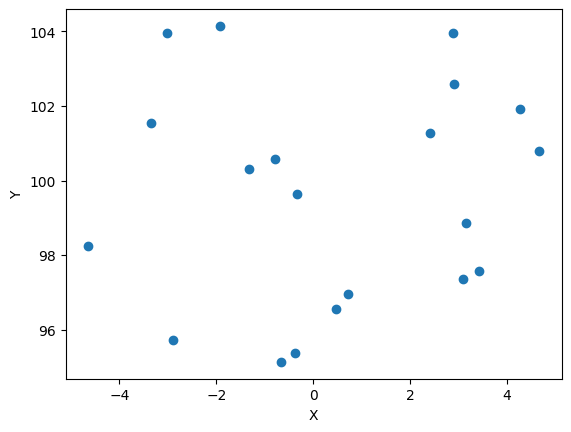

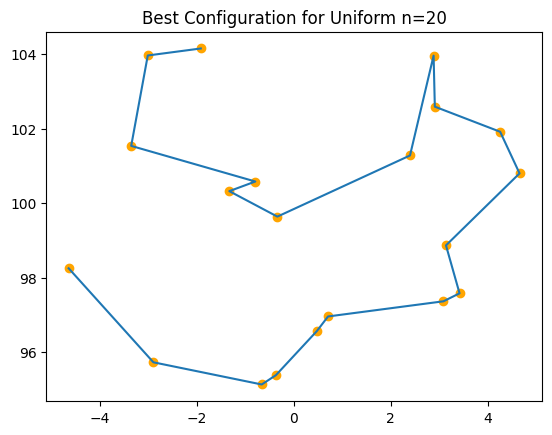

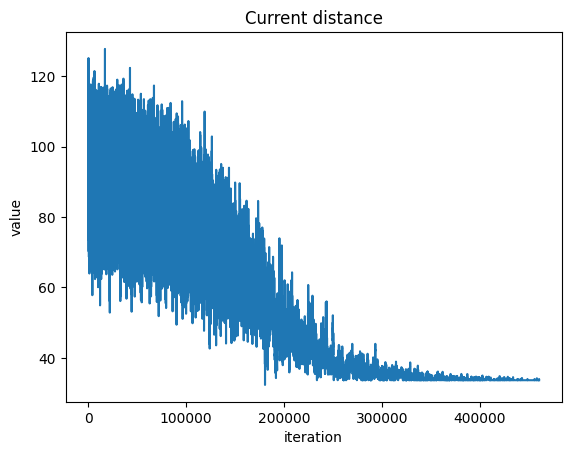

Found best distance for  Uniform n=20 :  32.32710564822873


In [27]:
#20
X,Y = generate_map(20,100,10,1)
simulatedAnnealingTSP(X,Y,euclideanDistance,"Uniform n=20",MinHeat=1e-1,InitialHeat=10,coolingRate=1e-5)

W grafie Dystansu można zauważyć początkową część losowego wyszukiwania, która wraz ze spatkiem temperatury zawęża się i stopniowo zbliża do spadku po gradieńcie (gradient descent<sup>[2]</sup>)

Gif przedstawiający ewolucje najlepszej ścieżki

![gifUniform n=20](gify/Uniform%20n=20TSP.gif)

Jak widać początkowo ruchy są bardzo duże i sporadyczne (ze względu na to że jest to najlepsza ścieżka, więc często dochodzi do "skoku" z danego minimum lokalnego do innego, co może trwać wiele iteracji), a pod koniec występują tylko małe i dokładne poprawki

<hr>

##### Porównanie dwóch metod dla przykładu średniej długości

W tej próbie wywołana zostanie funkcje dwa razy dla tego samego grafu, porównując wersje z losowym i arbitralnym wyborem drugiego indeksu

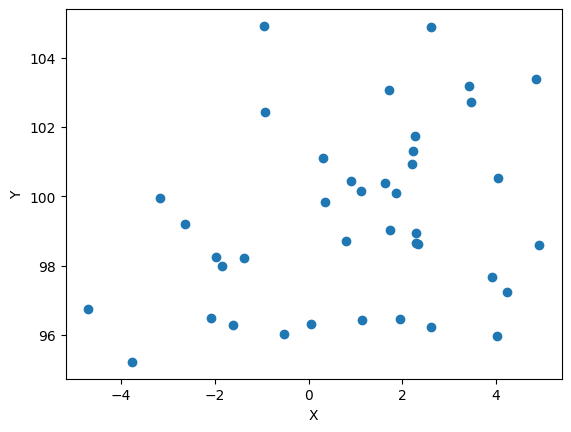

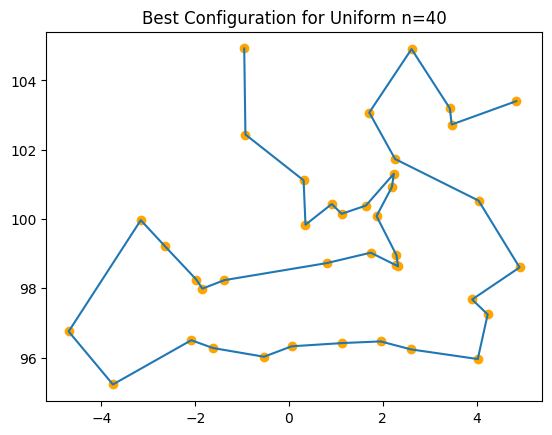

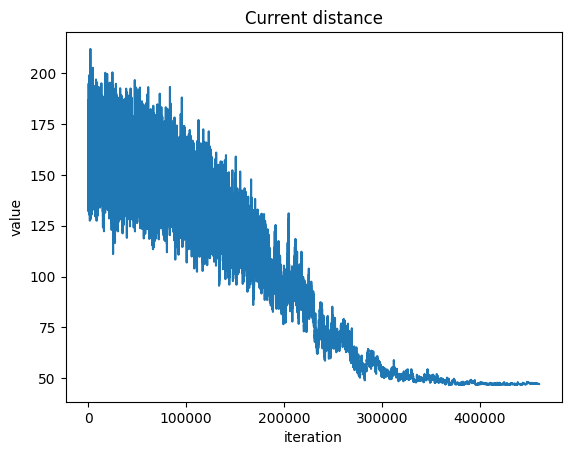

Found best distance for  Uniform n=40 :  46.73757673506737


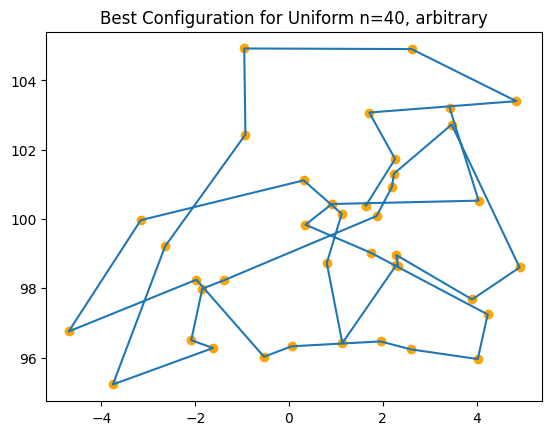

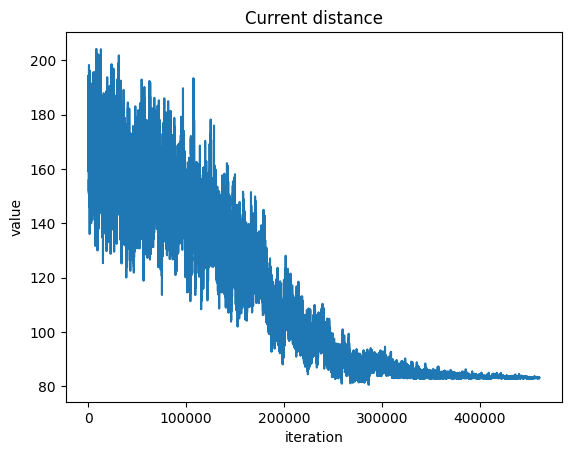

Found best distance for  Uniform n=40, arbitrary :  80.54534569488845


In [29]:
#40
X,Y = generate_map(40,100,10,1)
simulatedAnnealingTSP(X,Y,euclideanDistance,"Uniform n=40",MinHeat=1e-1,InitialHeat=10,coolingRate=1e-5)
#arbitrary
simulatedAnnealingTSP(X,Y,euclideanDistance,"Uniform n=40, arbitrary",arbitrary=True,MinHeat=1e-1,InitialHeat=10,coolingRate=1e-5)

Jak widać losowy wybór dla Jednego kwadratu ma dużą różnice w jakości wzgędem arbitralnego. Prawdopodobnie jest to spowodowane faktem, że dla arbirtralnego trzeba zdecydowanie więcej sukcesów prawdopodobieństwa aby "wyskoczyć" z danego minima lokalnego, co sprawiałoby że jeżeli już funkcja wpadnie w jedno z nich, to zdecydowanie trudniej będzie się z niego wydostać

Porównanie gifów:

![Gifuniform n=40](gify/Uniform%20n=40TSP.gif)
![Gifuniform n=40,arbitrary](gify/Uniform%20n=40,%20arbitraryTSP.gif)

Jak widać zmiany w losowym są zdecydowanie bardziej skokowe, co ułatwia znalezienie lepszych minimów lokalnych, co z kolei zwiększa szanse na zbliżenie się do minimum globalnego

<hr>

##### Test dla dużego n

W tym teście będziemy porównywać zachowanie funkcji dla zwiększonych parametrów, (zwiększona ilośc punktów, ale także zdecydowanie zwiększenie iteracji, zakresów i stopnia chłodzenia)

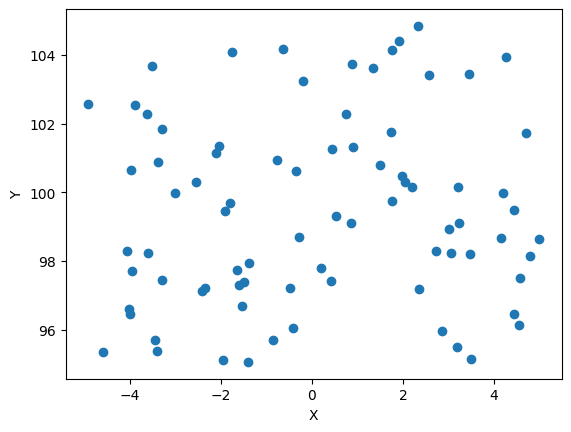

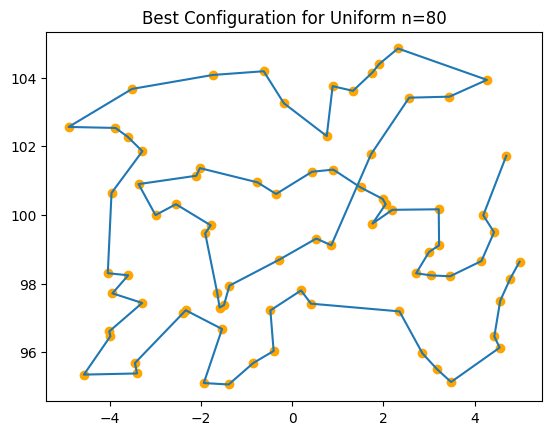

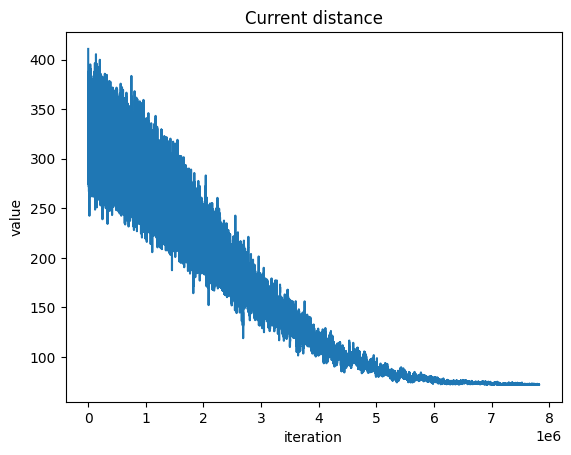

Found best distance for  Uniform n=80 :  71.86324774268824


In [25]:
#80
X,Y = generate_map(80,100,10,1)
simulatedAnnealingTSP(X,Y,euclideanDistance,"Uniform n=80",MinHeat=1e-1,InitialHeat=5,coolingRate=5e-7)

Pierwszą różnicą jest ewidentnie dłuższy czas wykonania (Ponad dziesięciokrotny wzrost iteracji wiąże się z ponad dziesięciokrotnym wzrostem czasu wykonania). Mimo tak długiego czasu wyniki są gorsze.

Jest to prawdopodobnie wywołane zdecydowanie większą ilością kombinacji, a za razem zdecydowanie większą szansą nie trafienia minima globalnego

![Uniform n=80 gif](gify/Uniform%20n=80TSP.gif)

Gif jest zdecydowanie dłuższy co także jest spodziewane i potwierdza wysuniętą teorie

<hr>

#### Punkty na kole

Te wywołania charakteryzują się bardzo schematycznym sposobem budowania, ponieważ w każdym z kompleksów znajduje się dokładnie jeden punkt

##### Proste wywołanie

Tym razem funkcje są wywołane dla n = 16 (zamiast poprzednich 20) z powodu, że wielokrotności dwójki w mojej skromnej opinii wyglądają lepiej. 

*dodatkowo z powodów generacji punktów każdy graf będzie miał swoją aproksymacje w celu porównania wielkości*

Aproximate best euclidean Distance for uniform distribution n=16:  584.8772278713271


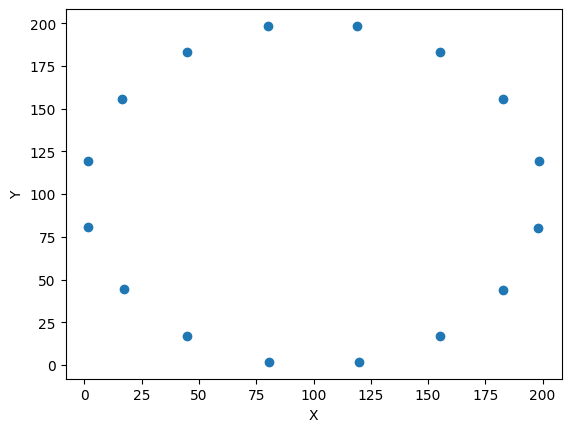

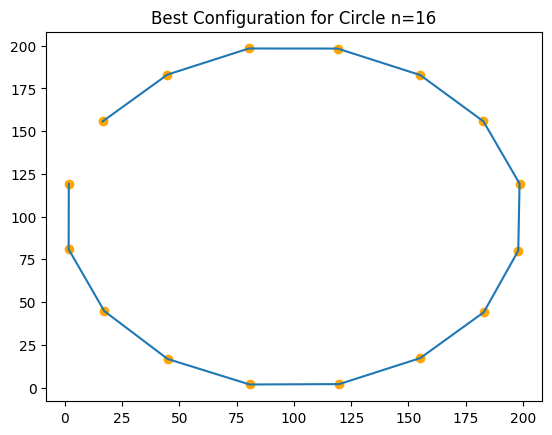

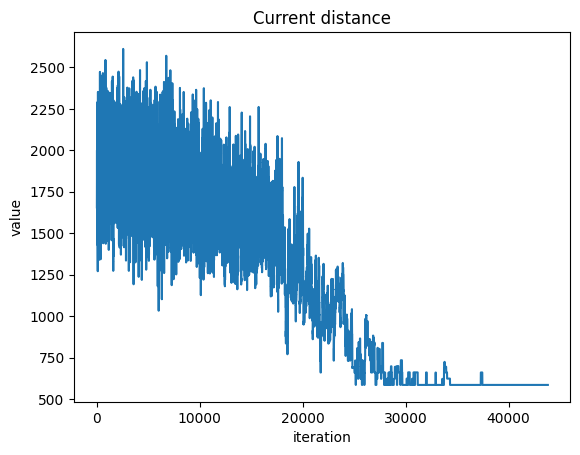

Found best distance for  Circle n=16 :  584.7098848701637


In [17]:
#16
X,Y = generate_map(16,100,1,16)
print("Aproximate best euclidean Distance for uniform distribution n=16: " , calculateTotalDistance(X,Y,[i for i in range(len(X))],euclideanDistance))
simulatedAnnealingTSP(X,Y,euclideanDistance,"Circle n=16",InitialHeat=400, MinHeat=5,coolingRate=1e-4)

Jak widać w tym prostym wywołaniu początek odpowiada bardziej losowemu poszukiwaniu, a analogicznie jak do pierwszego przykładu koniec przypomina prosty *gradient descent*

![gifcirclen=16](gify/Circle%20n=16TSP.gif)

<hr>

##### Porównanie dwóch wersji

Teraz zostanią porównane obie wersje wyznaczania indexów, losowo i arbitralnie

Aproximate best euclidean Distance for uniform distribution n=32:  608.0838091556559


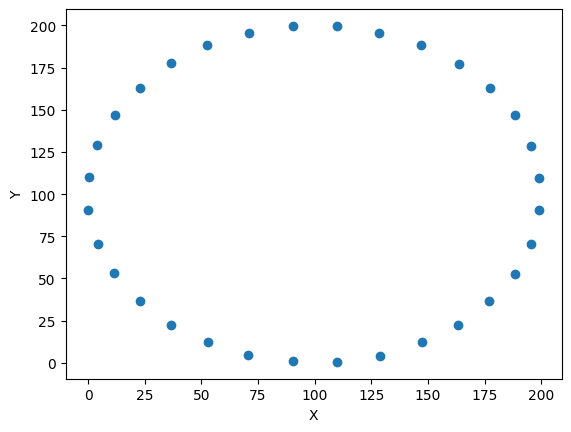

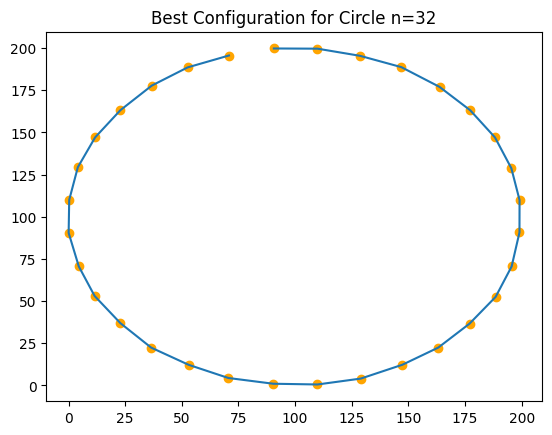

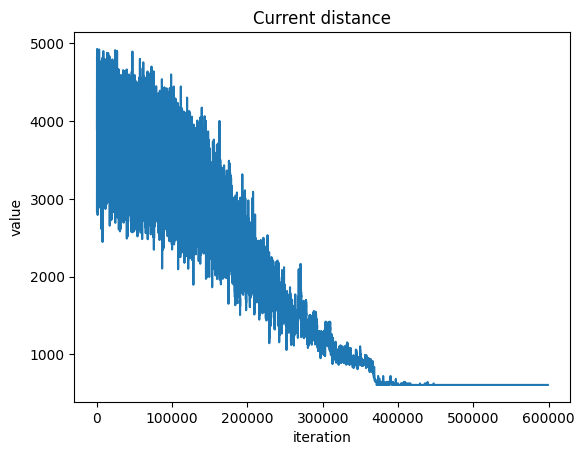

Found best distance for  Circle n=32 :  606.9951336305137


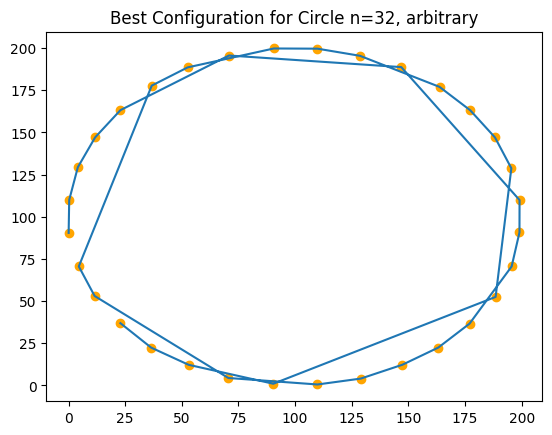

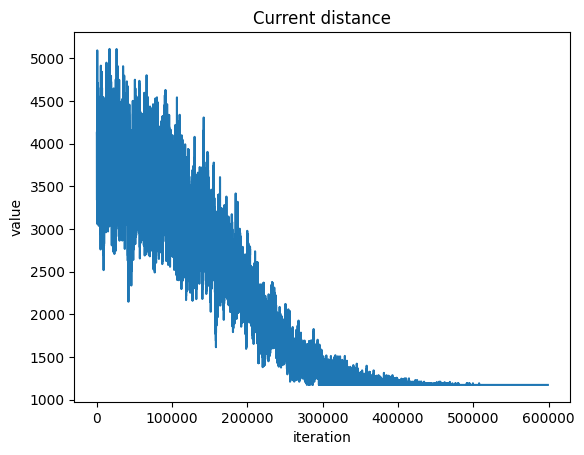

Found best distance for  Circle n=32, arbitrary :  1171.288856090359


In [18]:
#32
X,Y = generate_map(32,100,1,32)
print("Aproximate best euclidean Distance for uniform distribution n=32: " , calculateTotalDistance(X,Y,[i for i in range(len(X))],euclideanDistance))
simulatedAnnealingTSP(X,Y,euclideanDistance,"Circle n=32", InitialHeat=400,coolingRate=1e-5,MinHeat=1)
#arbitrary
simulatedAnnealingTSP(X,Y,euclideanDistance,"Circle n=32, arbitrary",arbitrary=True, InitialHeat=400,coolingRate=1e-5,MinHeat=1)

Można zauważyć ewidentną różnice w losowości - wersja dla arbitralnej zmiany indeksów ma wcięcia (prawdopodobnie ze względu na to że w niektórych konfiguracjach najzwyczajniej w świecie nie da się zrobić skrajnie większej/mniejszej), natomiast wersja dla losowej zmiany indeksów jest bardziej pełna, co może oznaczać większą swobode dla tworzenia kolejnej iteracji. Prawdopodobnie swoboda ta wpływa pozytywnie na generacje wyników co jest odzwierciedlone w wyniku dla tych samych parametrów - wersja losowa znalazła optymalne rozwiązanie, a wersja arbitralna nie

![gifcircle32](gify/Circle%20n=32TSP.gif)
![gifcircle32arbitrary](gify/Circle%20n=32,%20arbitraryTSP.gif)

Różnica w gifie jest podobna do tej z poprzedniej konfiguracji

<hr>

##### Test dla dużej wartości

Teraz sprawdze zachowanie grafu dla dużej liczby punktów

Aproximate best euclidean Distance for Circle distribution n=128:  625.9055090586813


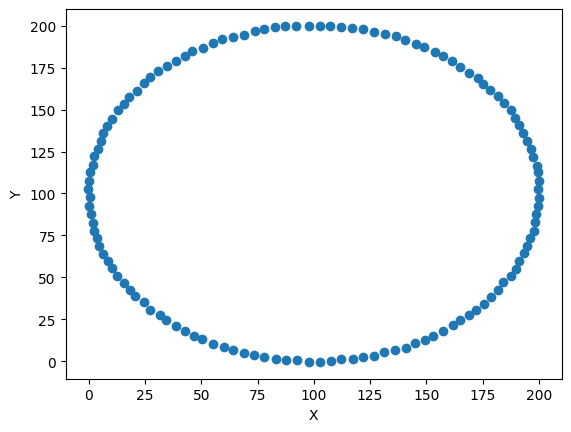

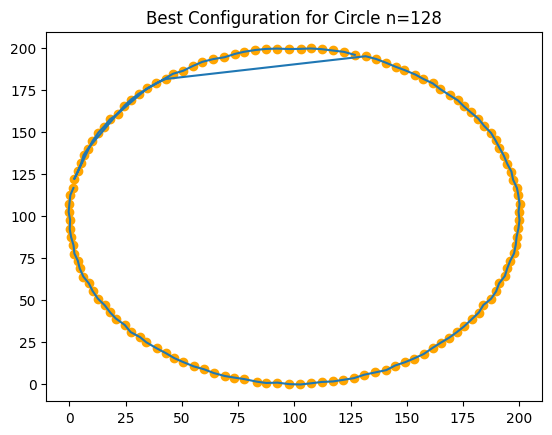

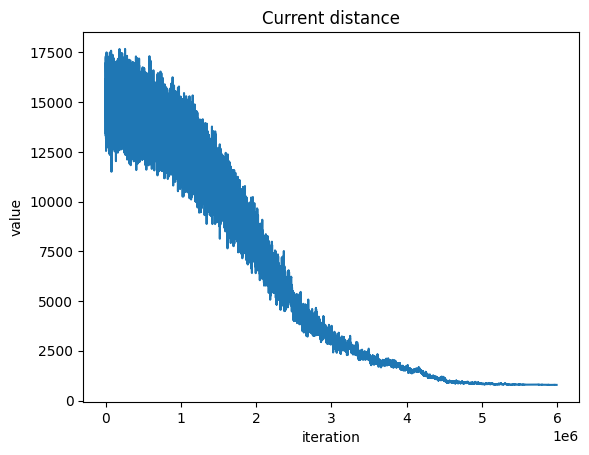

Found best distance for  Circle n=128 :  784.327598803746


In [19]:
#64
X,Y = generate_map(128,100,1,128)
print("Aproximate best euclidean Distance for Circle distribution n=128: " , calculateTotalDistance(X,Y,[i for i in range(len(X))],euclideanDistance))
simulatedAnnealingTSP(X,Y,euclideanDistance,"Circle n=128",InitialHeat=400,coolingRate=1e-6,MinHeat=1)

Bardzo dobry wynik i przepiękny wykres energii, biorąc pod uwage wielkość tego grafu. Taki piękny wynik niestety jest pokryty 4krotnie większym czasem wywołania i ponad 6,000,000 iteracji potrzebnych do uzyskania optymalnego rozwiązania

![gifcirclebig](gify/Circle%20n=128TSP.gif)

Gif coprawda bardzo długi, lecz za to w mojej skromej opinni piękny, widać małe poprawki jak I wielkie skoki w poszukiwaniu minimum

<hr>

#### Grafy mostowe

Wybrałem dwie wersje grafów z mostami - zawierające 4 kompleksy i 9 kompleksów, dzięki temu możemy porównywać jak bardzo zwiększać bądź zmiejszać potrzebujemy parametry aby otrzymać wyniki podobnej jakości

##### Wywołanie proste

wywołanie to ma na celu postawić różnice w parametrach dla małego n i pokazać koncept grafów z kompleksami

Aproximate best euclidean Distance for quadruple distribution n=18:  521.6542559713615


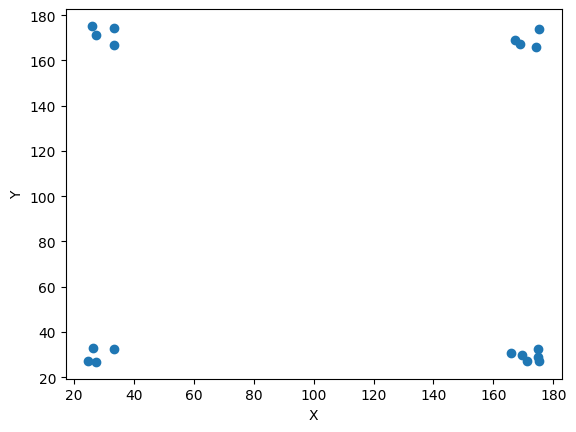

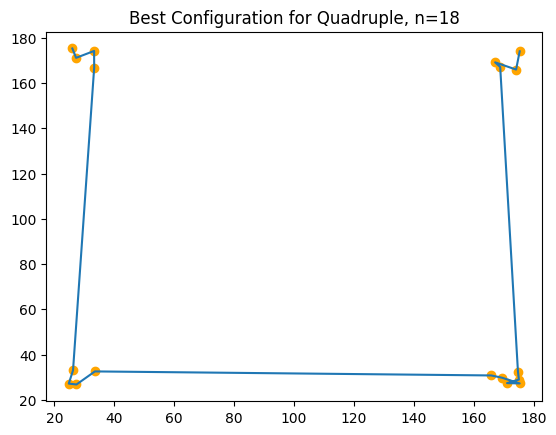

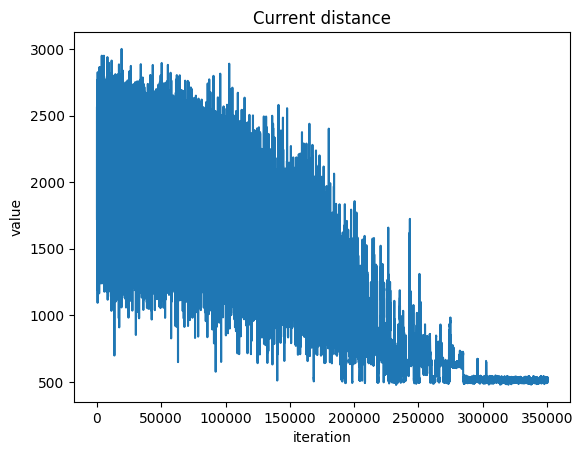

Found best distance for  Quadruple, n=18 :  477.0955258296643
Aproximate best euclidean Distance for ninefold distribution n=18:  593.3704608687372


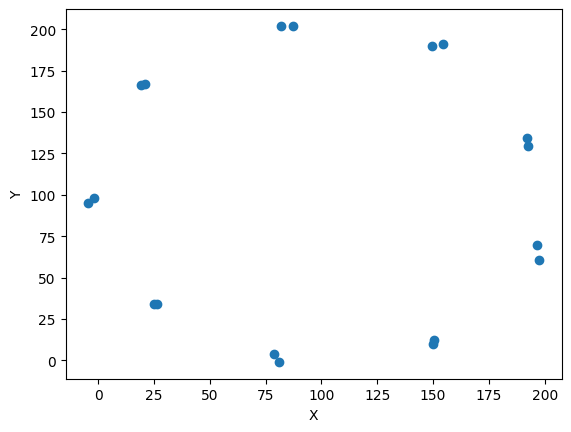

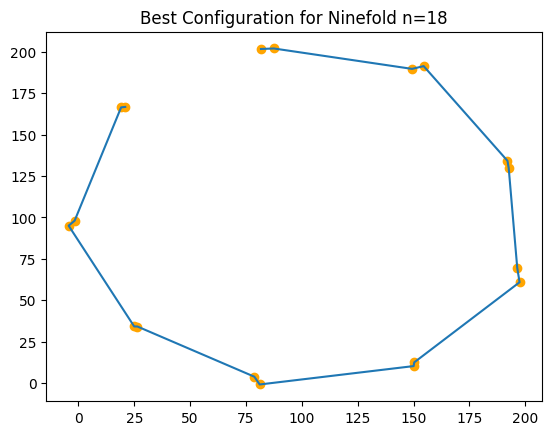

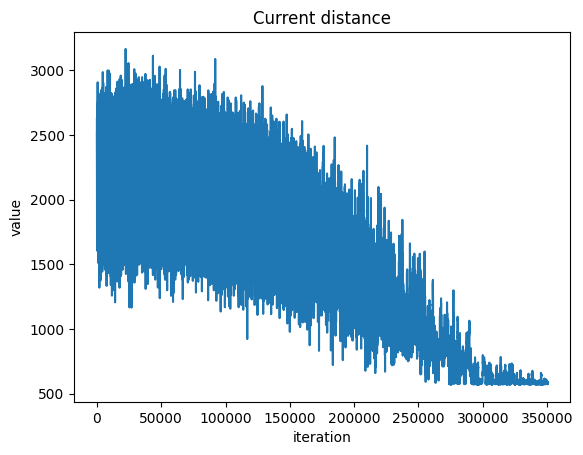

Found best distance for  Ninefold n=18 :  568.1160916900213


In [20]:
#18
#4 complexes
X,Y = generate_map(18,100,10,4)
print("Aproximate best euclidean Distance for quadruple distribution n=18: " , calculateTotalDistance(X,Y,[i for i in range(len(X))],euclideanDistance))
simulatedAnnealingTSP(X,Y,euclideanDistance, "Quadruple, n=18",InitialHeat=500,coolingRate=1e-5,MinHeat=15)

#9 complexes
X,Y = generate_map(18,100,10,9)
print("Aproximate best euclidean Distance for ninefold distribution n=18: " , calculateTotalDistance(X,Y,[i for i in range(len(X))],euclideanDistance))
simulatedAnnealingTSP(X,Y,euclideanDistance, "Ninefold n=18",InitialHeat=500,coolingRate=1e-5,MinHeat=15)

Jak widać po wykresach energii (dystansu) dla wersji z 4 kompleksami wykres szybciej osiąga wartość minimalną (o około 3-5 tysięcy iteracji szybciej)

![gif4n=18](gify/Quadruple,%20n=18TSP.gif)
![gif9n=18](gify/Ninefold%20n=18TSP.gif)

<hr>

##### Wywołanie porównujące normalny z arbitralnym


Aproximate best euclidean Distance for quadruple distribution n=36:  586.9561238834622


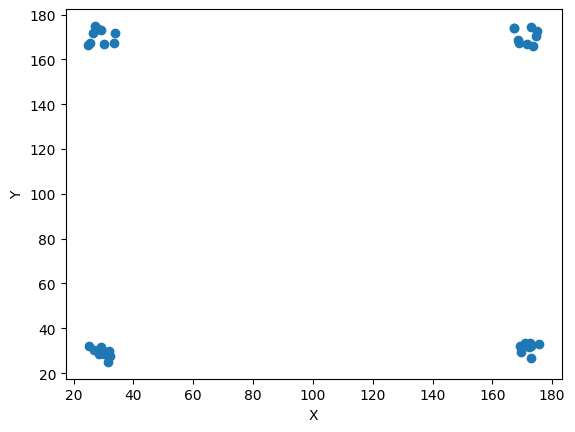

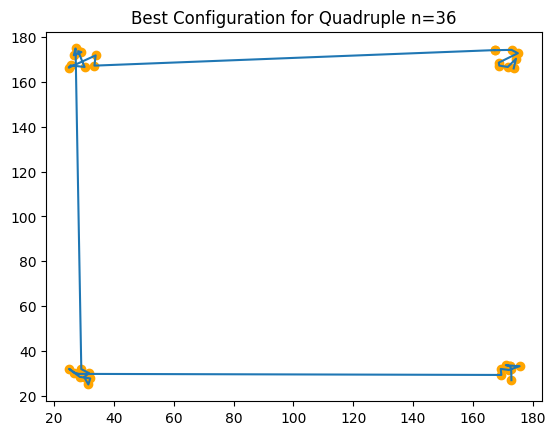

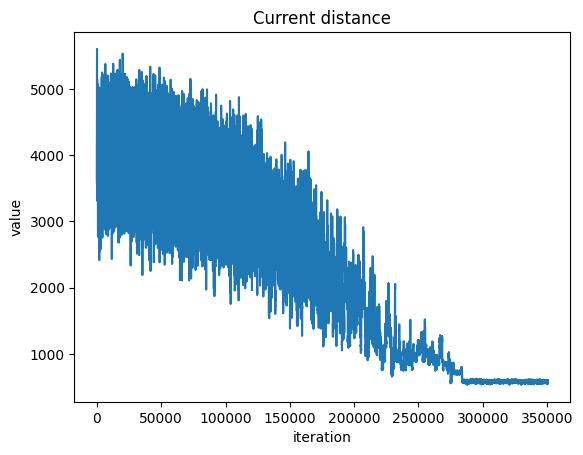

Found best distance for  Quadruple n=36 :  529.7406468793765


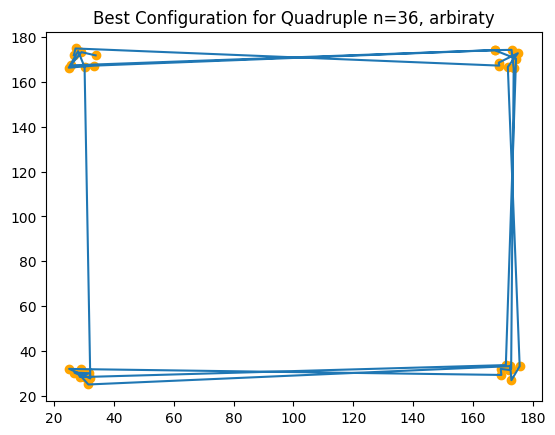

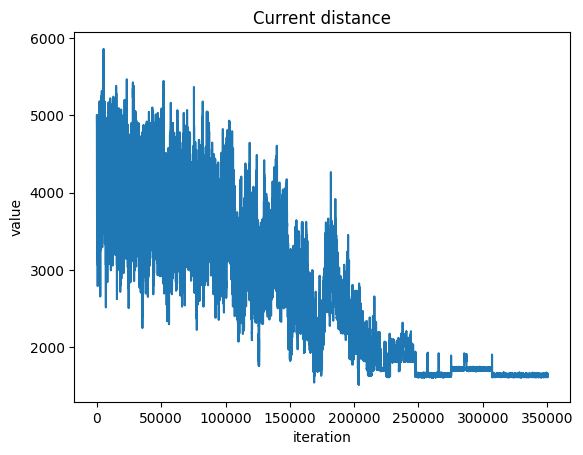

Found best distance for  Quadruple n=36, arbiraty :  1512.5129497155472
Aproximate best euclidean Distance for ninefold distribution n=36:  681.8750081660314


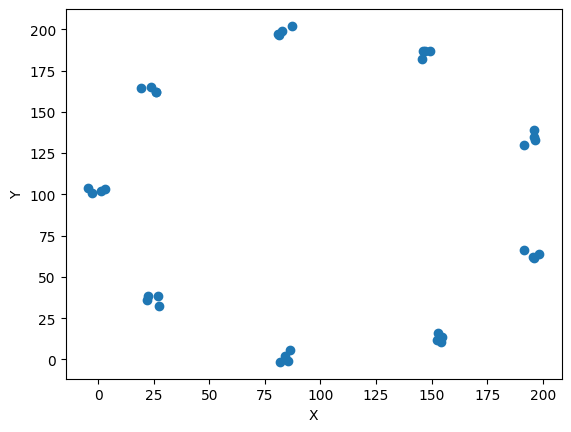

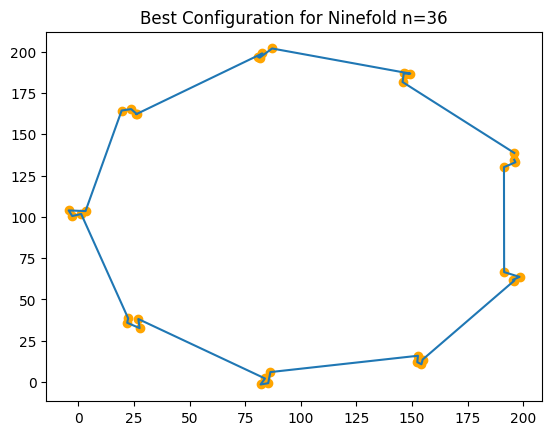

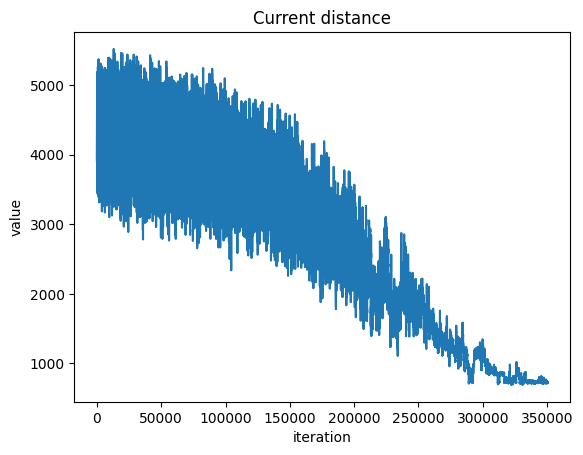

Found best distance for  Ninefold n=36 :  690.052851777384


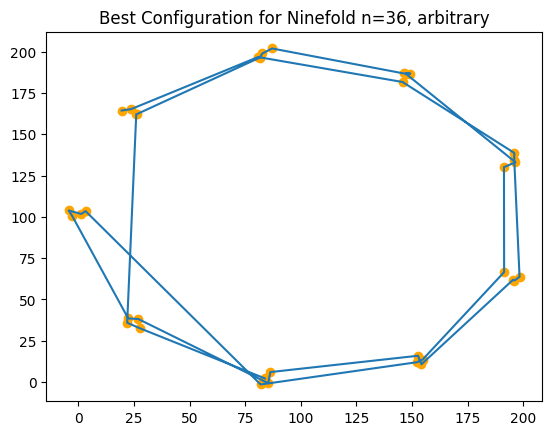

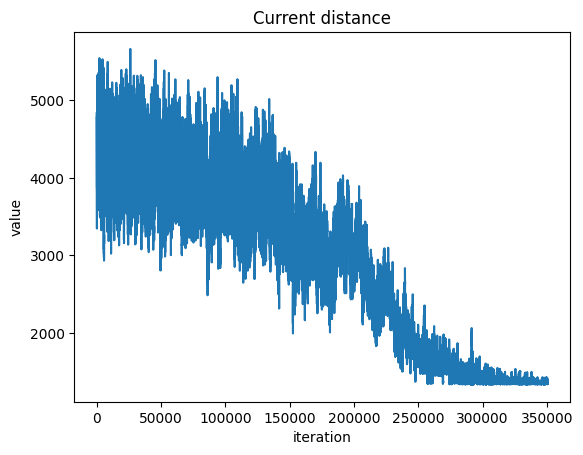

Found best distance for  Ninefold n=36, arbitrary :  1329.8097656758762


In [21]:
#32
#4
X,Y = generate_map(36,100,10,4)
print("Aproximate best euclidean Distance for quadruple distribution n=36: " , calculateTotalDistance(X,Y,[i for i in range(len(X))],euclideanDistance))
simulatedAnnealingTSP(X,Y,euclideanDistance, "Quadruple n=36",InitialHeat=500,coolingRate=1e-5,MinHeat=15)
#arbitrary
simulatedAnnealingTSP(X,Y,euclideanDistance, "Quadruple n=36, arbiraty",arbitrary=True,InitialHeat=500,coolingRate=1e-5,MinHeat=15)

#9
X,Y = generate_map(36,100,10,9)
print("Aproximate best euclidean Distance for ninefold distribution n=36: " , calculateTotalDistance(X,Y,[i for i in range(len(X))],euclideanDistance))
simulatedAnnealingTSP(X,Y,euclideanDistance, "Ninefold n=36",InitialHeat=500,coolingRate=1e-5,MinHeat=15)
#arbitrary
simulatedAnnealingTSP(X,Y,euclideanDistance,"Ninefold n=36, arbitrary", arbitrary=True,InitialHeat=500,coolingRate=1e-5,MinHeat=15)

Wyniki dla arbitralnych jak zwykle różne, wszystkie wcześniej zaznaczone rzeczy dalej zdają się być prawdziwe. Interesujące natomiast jest że zwykła konfiguracja dla 9 kompleksów tym razem nie znalazła optymalnego rozwiązania, co widać po dodatkowym moście

Gify dla 4 kompleksów

![gif4n=36](gify/Quadruple%20n=36TSP.gif)
![gif4n=36arbitrary](gify/Quadruple%20n=36,%20arbiratyTSP.gif)

Natomiast dla 9

![gif9n=36](gify/Ninefold%20n=36TSP.gif)
![gif9n=36arbitrary](gify/Ninefold%20n=36,%20arbitraryTSP.gif)

<hr>

##### Test dla dużych wartości

prawdopodobnie najciekawczy test z tego zestawienia

Aproximate best euclidean Distance for quadruple distribution n=144:  1133.4908717188225


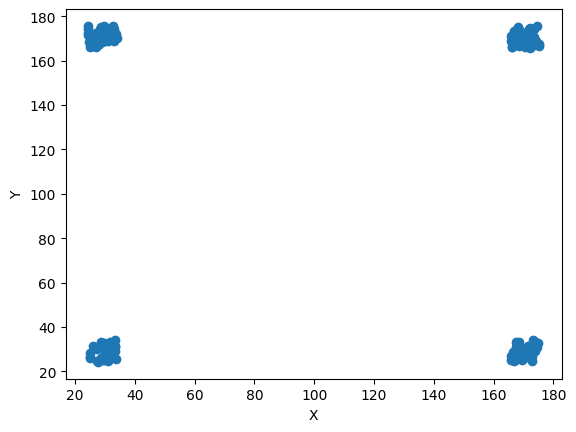

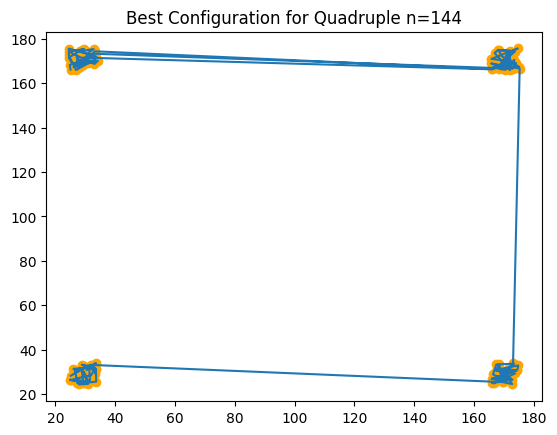

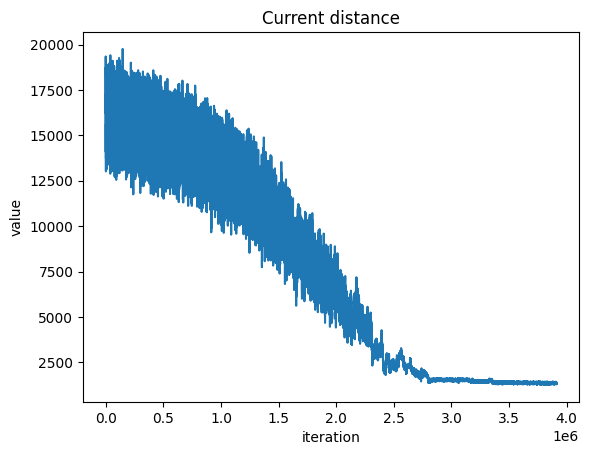

Found best distance for  Quadruple n=144 :  1252.6642706578666
Aproximate best euclidean Distance for ninefold distribution n=144:  1184.4339267928246


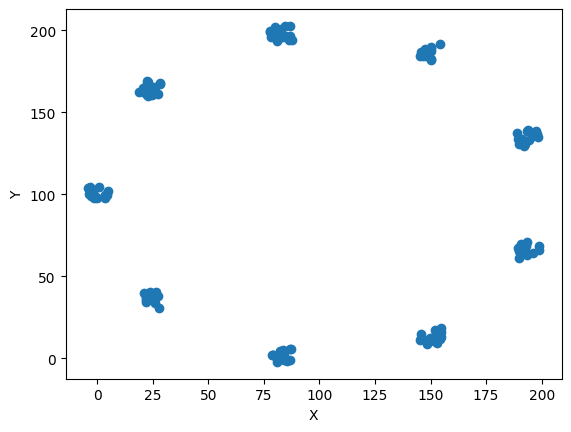

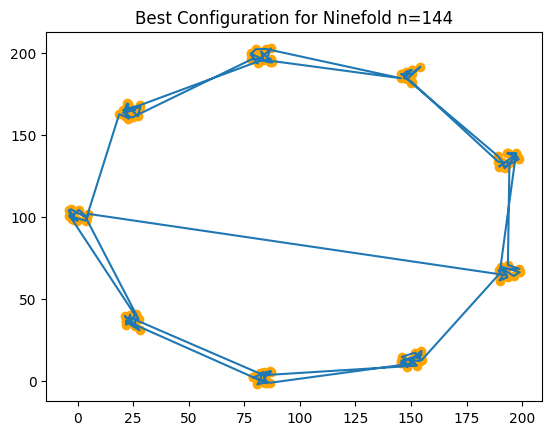

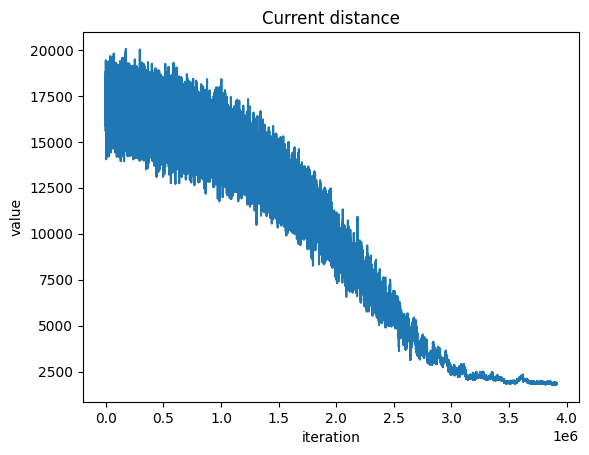

Found best distance for  Ninefold n=144 :  1783.74791131023


In [22]:
#64
#4
X,Y = generate_map(144,100,10,4)
print("Aproximate best euclidean Distance for quadruple distribution n=144: " , calculateTotalDistance(X,Y,[i for i in range(len(X))],euclideanDistance))
simulatedAnnealingTSP(X,Y,euclideanDistance, "Quadruple n=144",InitialHeat=500,coolingRate=1e-6,MinHeat=10)
#9
X,Y = generate_map(144,100,10,9)
print("Aproximate best euclidean Distance for ninefold distribution n=144: " , calculateTotalDistance(X,Y,[i for i in range(len(X))],euclideanDistance))
simulatedAnnealingTSP(X,Y,euclideanDistance, "Ninefold n=144",InitialHeat=500,coolingRate=1e-6,MinHeat=10)

Różnica jest zaskakująco mała, aczkolwiek jest. 500,000 iteracji więcej do osiągnięcia minimum i kilka mostów więcej. Jest ona oczywiście wywołana większą ilością możliwych mostów w konfugiracji z 9 kompleksami.

![gif4dużo](gify/Quadruple%20n=144TSP.gif)
![gif9dużo](gify/Ninefold%20n=144TSP.gif)

### Podsumowanie
Używanie symulowanego wyżarzania w problemie TSP wydaje się być bardzo dobrym pomysłem ze względu na jego prostote w kodzie. Dodatkowo wg moich obserwacji:
- Zwiększanie startowego ciepła wydłuża czas losowego szukania
- Zwiększanie minimalnego ciepła wydłuża ogon
- zwiększanie tempa chłodzenia zmienia nachylenie i grubość części środkowej

<hr>

## Zadanie drugie - Segregacja macierzy

Dana jest macierz nxn zawierająca tylko zera i jedynki. Zero jest reprezentowane jako biały piksel, natomiast jeden jako czarny. Następnie stosując serię zamian doprowadzić do specyficznego stanu.

Skoro chcemy uzyskać jakiś stan - funkcja którą chcemy minimalizować ma być odwzdwierciedleniem stanu przeciwnego - większa energia $\iff$ stan mniej chciany

### Wizualizacja macierzy

W celu wizualizacji macierzy użyłem **Image** z biblioteki **PIL**. Zamienia ona macierz na obraz gdzie każda wartość w danej macierzy oznacza  wartość w stopniu szarości (od 0 do 255), gdzie 0 to czarny a 255 to biały. Trzeba więc to przekonwertować na przyjazną nam forme. Do tego użyjemy danej funkcji:

In [30]:
def visualizeMatrix(M,path):
    Matrix = np.array(M,dtype=np.uint8)
    inverted_array = 255 - Matrix * 255
    data = Image.fromarray(inverted_array)
    data.save(path)

### Główna funkcja

W odróżnieniu od funkcji z poprzedniego zadania nie wykonuje żadnych operacji podczas znalezienia nowego najlepszego wyniku, ponieważ według testów wywołanie funkcji wraz z zapisywaniem najlepszego wyniku spowalnia kod mniejwięcej 50cio krotnie. (Co dla dużych liczb oznacza zmiane z minuty na 50 minut trwania kodu)

Dodatkowo:
- rozdzielone została funkcja wyznaczania energii i funkcja wyznaczania różnicy energii 
- każda macierz jest tworzona losowo na początku wywołania wraz z parametrami n i $\delta$
- zostaje wywołany bardzo podobny proces co do losowego TSP (wybieramy losowe 2 punkty, zamieniamy je jeżeli mają różne wartości, wyliczamy różnice stanów, używamy funkcji prawdopodobieństwa, zamieniamy, powtarzamy)


In [34]:
def zad2(n,delta,energyDiffFunction,pointEnergyFunction,path,StartingHeat=5e1,CoolingRate=1e-5,HeatLimit=1e-10):

    #print("\n\n\n==============", path, "===========")
      
    #create matrix
    M = [[1 if random.random() < delta else 0 for _ in range(n)] for _ in range(n)]
    Heat = StartingHeat
    coolingRate = CoolingRate
    #calculate initial energy
    currEnergy = 0
    for i in range(n):
        for j in range(n):
            currEnergy += pointEnergyFunction(M,(i,j))
    visualizeMatrix(M,"lab4zad2/" + path + 'Start.png')

    Energy = []

    for i in range(100000000):
        if Heat <= HeatLimit:
            break
    
        #change values
        x_1,y_1,x_2,y_2 = random.randint(0,n-1),random.randint(0,n-1),random.randint(0,n-1),random.randint(0,n-1)
        #swaping 1 with 1 and 0 with 0 dosent do anything
        if M[x_1][y_1] == M[x_2][y_2]:
            continue
        point1 = (x_1,y_1)
        point2 = (x_2,y_2)

        EnergyDiff = energyDiffFunction(M,point1, point2)
        if( calcAccteptancePropability(EnergyDiff,Heat) > random.random()):
            newEnergy = currEnergy + EnergyDiff
            currEnergy = newEnergy
        
        else:
            #swap
            M[point1[0]][point1[1]], M[point2[0]][point2[1]] = M[point2[0]][point2[1]],M[point1[0]][point1[1]]

        Energy.append(currEnergy)
        Heat *= 1-coolingRate
        
    plt.figure()
    plt.title(path + ' Energy Graph')
    plt.xlabel('iteration')
    plt.ylabel('value')
    plt.plot(Energy)
    visualizeMatrix(M,"lab4zad2/" + path + 'End.png')

### Wywołania i różne sposoby liczenia energii
W celach ilustracji i porównania każdy ze sposobów będzie miał 6 przykładów dla odpowiednio n = 20 i n = 500 jak i dla $\delta$ = 0,1; 0,2; 0,4 

*Uwaga: ze względu na ograniczenia zwiększania obrazu w plikach typu Markdown przykłady dla n = 20 nie zostaną wyświetlone, można je natomiast otworzyć w plikach pod adekwatnymi nazwami (zawierającymi "n = 20")*


#### Sposób 1 - segregacja czarnych i białych pixeli na grupy

Funkcja nasza dla każdego punktu policzy sume jego 8 sąsiadów - jeżeli pixel jest biały i ma sąsiada czarnego dostaje punkt, natomiast jeżeli sąsiadem tego punktu jest pixel biały to nie dostaje punktu energii wcale (i analogicznie z odwróconymi kolorami)

Przy minimalizowaniu powinniśmy uzyskać efekt grupowania - czarne pixele będą starały się trzymać blisko czarnych pixeli a białe białych.

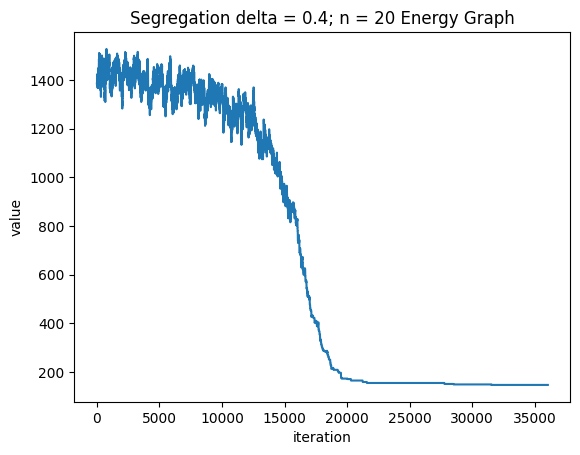

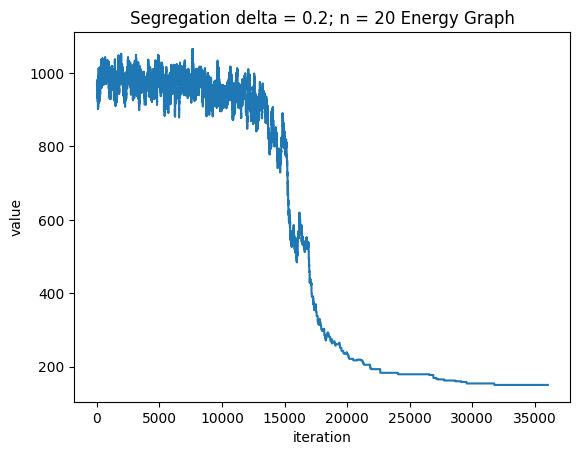

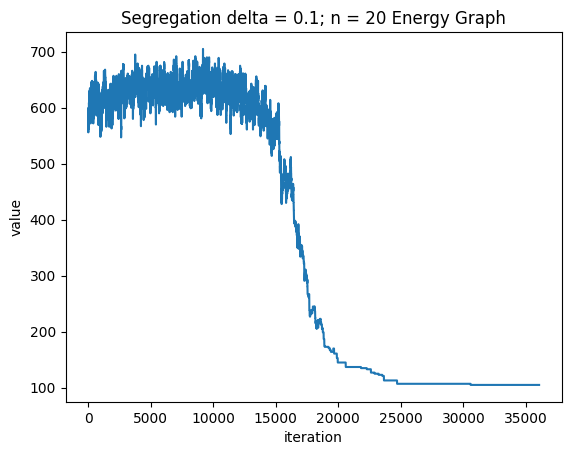

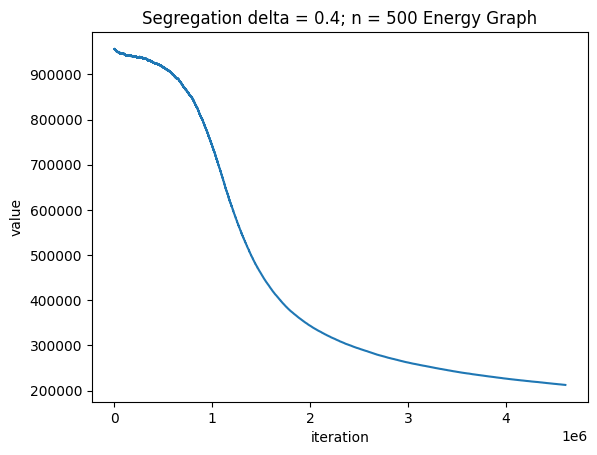

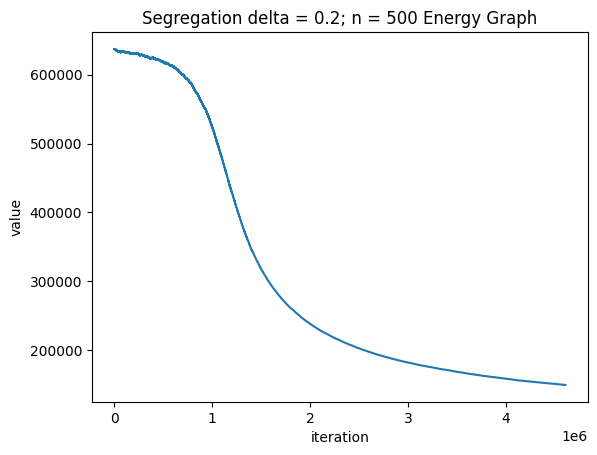

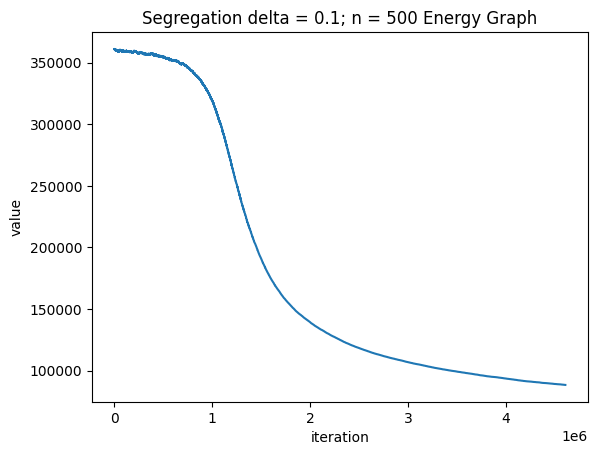

In [35]:
def calculatePointEnergy1(M,point:tuple[int,int]):
    #blacks close to whites, whites close to blacks
    #we want to minimise it so we want as many blacks close to blacks and whites close to whites

    n = len(M)
    i = point[0]
    j = point[1]
    energy = 0 
    bonus = M[i][j]
    if j - 1 >= 0 and i - 1 >= 0:
        energy += (M[i-1][j-1] + bonus) % 2
    if j-1 >= 0:
        energy += (M[i][j-1] + bonus) % 2
    if i-1 >= 0:
        energy += (M[i-1][j] + bonus) % 2

    if j + 1 <= n-1 and i + 1 <= n-1:
        energy += (M[i+1][j+1] + bonus) % 2   
    if j + 1 <= n-1:
        energy += (M[i][j+1] + bonus) % 2
    if i + 1 <= n-1:
        energy += (M[i+1][j] + bonus) % 2   
    if j + 1 <= n-1 and i - 1 >= 0:
        energy += (M[i-1][j+1] + bonus) % 2   
    if j - 1 >= 0 and i + 1 <= n-1:
        energy += (M[i+1][j-1] + bonus) % 2  

    return energy

def calculateEnergyDiff1(M,point1:tuple[int,int],point2:tuple[int,int]):
    n = len(M)
    StartEnergy = 0

    for i in range(max(0,point1[0]-1),min(point1[0]+2,n)):
        for j in range(max(0,point1[1]-1),min(point1[1]+2,n)):
            StartEnergy += calculatePointEnergy1(M,(i,j))

    for i in range(max(0,point2[0]-1),min(point2[0]+2,n)):
        for j in range(max(0,point2[1]-1),min(point2[1]+2,n)):
            StartEnergy += calculatePointEnergy1(M,(i,j))  

    #swap
    M[point1[0]][point1[1]], M[point2[0]][point2[1]] = M[point2[0]][point2[1]],M[point1[0]][point1[1]]


    EndEnergy = 0
    for i in range(max(0,point1[0]-1),min(point1[0]+2,n)):
        for j in range(max(0,point1[1]-1),min(point1[1]+2,n)):
            EndEnergy += calculatePointEnergy1(M,(i,j))

    for i in range(max(0,point2[0]-1),min(point2[0]+2,n)):
        for j in range(max(0,point2[1]-1),min(point2[1]+2,n)):
            EndEnergy += calculatePointEnergy1(M,(i,j))  

    return EndEnergy-StartEnergy


zad2(20,0.4,calculateEnergyDiff1,calculatePointEnergy1,"Segregation delta = 0.4; n = 20",5e2,3e-4,1e-2)
zad2(20,0.2,calculateEnergyDiff1,calculatePointEnergy1,"Segregation delta = 0.2; n = 20",5e2,3e-4,1e-2)
zad2(20,0.1,calculateEnergyDiff1,calculatePointEnergy1,"Segregation delta = 0.1; n = 20",5e2,3e-4,1e-2)
zad2(500,0.4,calculateEnergyDiff1,calculatePointEnergy1,"Segregation delta = 0.4; n = 500",1e2,3e-6,1e-4)
zad2(500,0.2,calculateEnergyDiff1,calculatePointEnergy1,"Segregation delta = 0.2; n = 500",1e2,3e-6,1e-4)
zad2(500,0.1,calculateEnergyDiff1,calculatePointEnergy1,"Segregation delta = 0.1; n = 500",1e2,3e-6,1e-4)

##### Zestawienie wyników

$\delta$ = 0.1

![](lab4zad2/Segregation%20delta%20=%200.1;%20n%20=%20500Start.png)
![](lab4zad2/Segregation%20delta%20=%200.1;%20n%20=%20500End.png)

$\delta$ = 0.2

![](lab4zad2/Segregation%20delta%20=%200.2;%20n%20=%20500Start.png)
![](lab4zad2/Segregation%20delta%20=%200.2;%20n%20=%20500End.png)

$\delta$ = 0.4

![](lab4zad2/Segregation%20delta%20=%200.4;%20n%20=%20500Start.png)
![](lab4zad2/Segregation%20delta%20=%200.4;%20n%20=%20500End.png)

Jak widać czarne pixele "zmierzają" do innych czarnych pixeli zgodnie z przewidywaniami

<hr>

#### Sposób 2 - szachownica

W tym sposobie chcemy aby sąsiedzi na przekątnej byli tego samego koloru a bezpośrednio obok byli przeciwnego koloru. A więc znów w funkji energie dodajemy w sytuacji przeciwnej

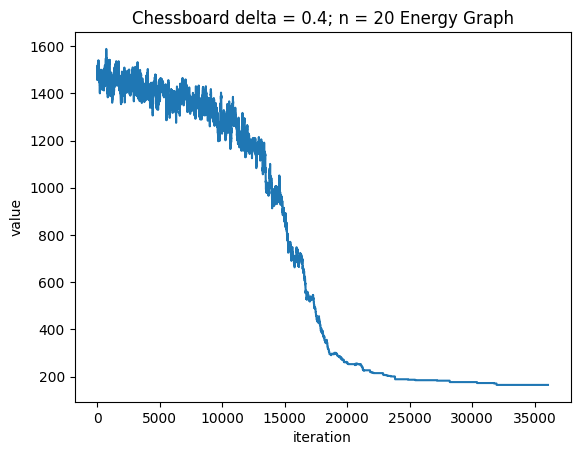

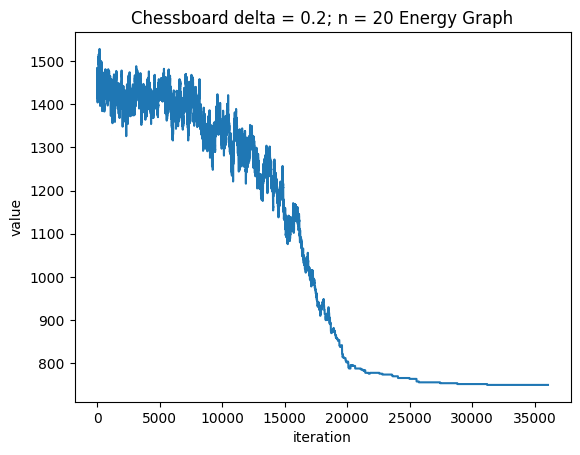

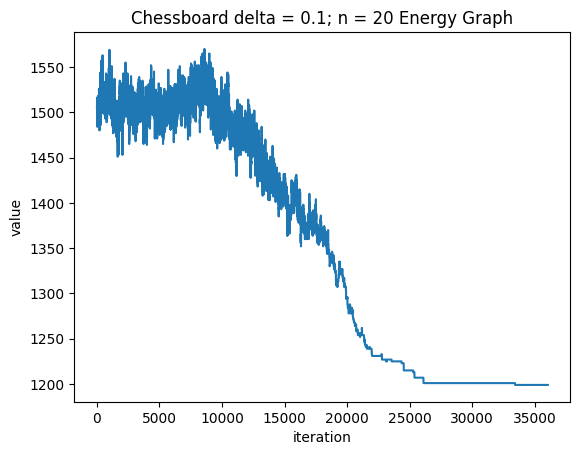

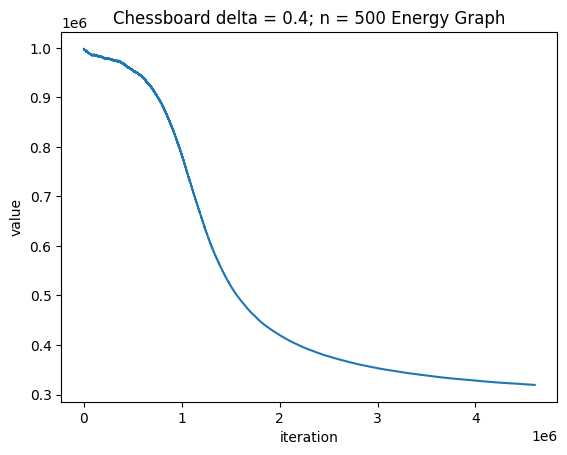

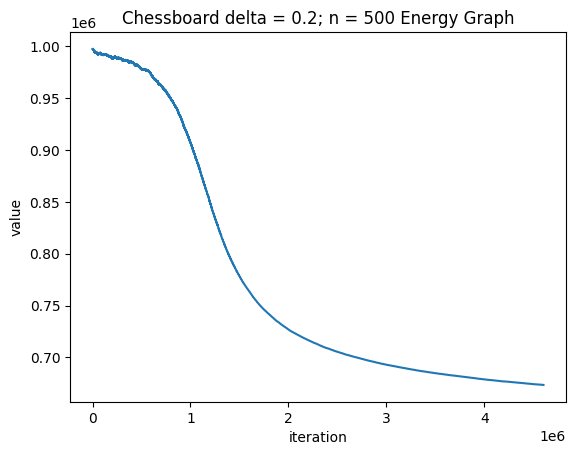

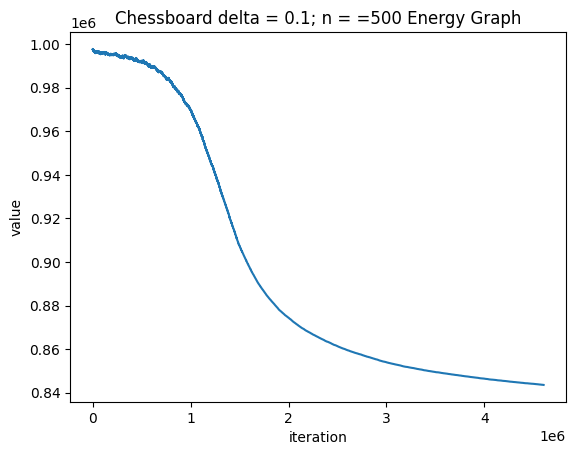

In [40]:
def calculatePointEnergy2(M,point:tuple[int,int]):
    pass
    n = len(M)
    i = point[0]
    j = point[1]
    energy = 0 
    bonus = M[i][j]
    if j - 1 >= 0 and i - 1 >= 0:
        energy += (M[i-1][j-1] + bonus) % 2
    if j-1 >= 0:
        energy += (M[i][j-1] + bonus + 1) % 2
    if i-1 >= 0:
        energy += (M[i-1][j] + bonus + 1) % 2

    if j + 1 <= n-1 and i + 1 <= n-1:
        energy += (M[i+1][j+1] + bonus) % 2   
    if j + 1 <= n-1:
        energy += (M[i][j+1] + bonus + 1) % 2
    if i + 1 <= n-1:
        energy += (M[i+1][j] + bonus + 1) % 2   

    if j + 1 <= n-1 and i - 1 >= 0:
        energy += (M[i-1][j+1] + bonus) % 2   
    if j - 1 >= 0 and i + 1 <= n-1:
        energy += (M[i+1][j-1] + bonus) % 2   

    return energy

def calculateEnergyDiff2(M,point1:tuple[int,int],point2:tuple[int,int]):
    n = len(M)
    StartEnergy = 0

    for i in range(max(0,point1[0]-1),min(point1[0]+2,n)):
        for j in range(max(0,point1[1]-1),min(point1[1]+2,n)):
            StartEnergy += calculatePointEnergy2(M,(i,j))

    for i in range(max(0,point2[0]-1),min(point2[0]+2,n)):
        for j in range(max(0,point2[1]-1),min(point2[1]+2,n)):
            StartEnergy += calculatePointEnergy2(M,(i,j))  

    #swap
    M[point1[0]][point1[1]], M[point2[0]][point2[1]] = M[point2[0]][point2[1]],M[point1[0]][point1[1]]


    EndEnergy = 0
    for i in range(max(0,point1[0]-1),min(point1[0]+2,n)):
        for j in range(max(0,point1[1]-1),min(point1[1]+2,n)):
            EndEnergy += calculatePointEnergy2(M,(i,j))

    for i in range(max(0,point2[0]-1),min(point2[0]+2,n)):
        for j in range(max(0,point2[1]-1),min(point2[1]+2,n)):
            EndEnergy += calculatePointEnergy2(M,(i,j))  

    return EndEnergy-StartEnergy

zad2(20,0.4,calculateEnergyDiff2,calculatePointEnergy2,"Chessboard delta = 0.4; n = 20",5e2,3e-4,1e-2)
zad2(20,0.2,calculateEnergyDiff2,calculatePointEnergy2,"Chessboard delta = 0.2; n = 20",5e2,3e-4,1e-2)
zad2(20,0.1,calculateEnergyDiff2,calculatePointEnergy2,"Chessboard delta = 0.1; n = 20",5e2,3e-4,1e-2)
zad2(500,0.4,calculateEnergyDiff2,calculatePointEnergy2,"Chessboard delta = 0.4; n = 500",1e2,3e-6,1e-4)
zad2(500,0.2,calculateEnergyDiff2,calculatePointEnergy2,"Chessboard delta = 0.2; n = 500",1e2,3e-6,1e-4)
zad2(500,0.1,calculateEnergyDiff2,calculatePointEnergy2,"Chessboard delta = 0.1; n = =500",1e2,3e-6,1e-4)

##### Zestawienie wyników

$\delta$ = 0.1

![](lab4zad2/Chessboard%20delta%20=%200.1;%20n%20=%20=500Start.png)
![](lab4zad2/Chessboard%20delta%20=%200.1;%20n%20=%20=500End.png)

$\delta$ = 0.2

![](lab4zad2/Chessboard%20delta%20=%200.2;%20n%20=%20500Start.png)
![](lab4zad2/Chessboard%20delta%20=%200.2;%20n%20=%20500End.png)

$\delta$ = 0.4

![](lab4zad2/Chessboard%20delta%20=%200.4;%20n%20=%20500Start.png)
![](lab4zad2/Chessboard%20delta%20=%200.4;%20n%20=%20500End.png)

Jak widać *(dokładniej widać otwierając bezpośrednio plik)* tworzą się kształty przypominające szachownice

<hr>

#### Sposób 3 - segregacja góra - dół

w tym sposobie warunek jest bardzo prosty - czarne pixele wolą być na górze a białe na dole

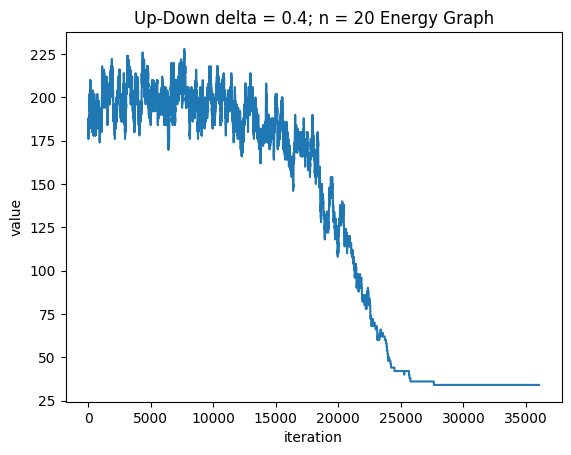

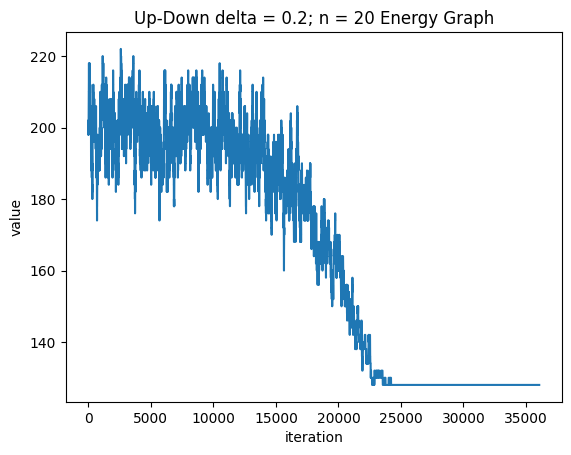

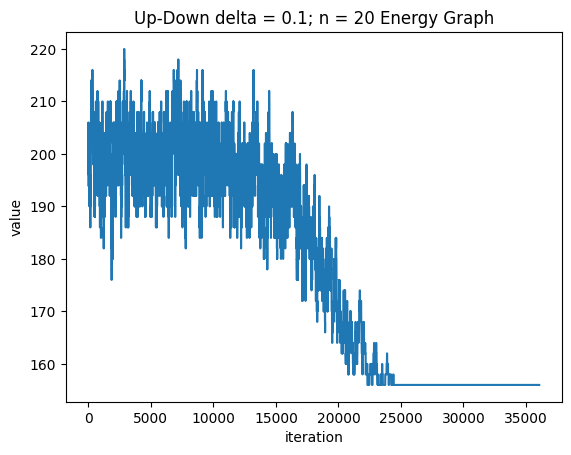

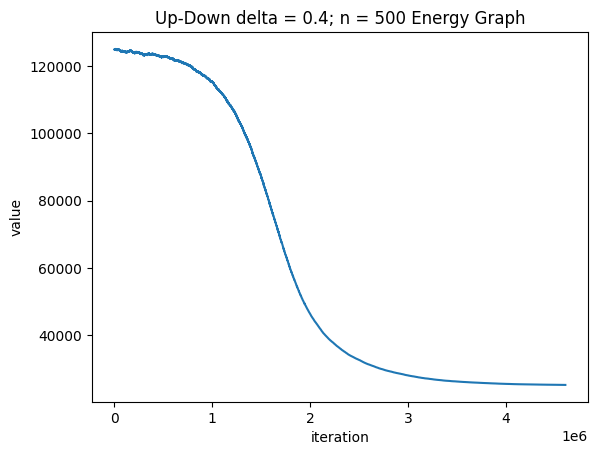

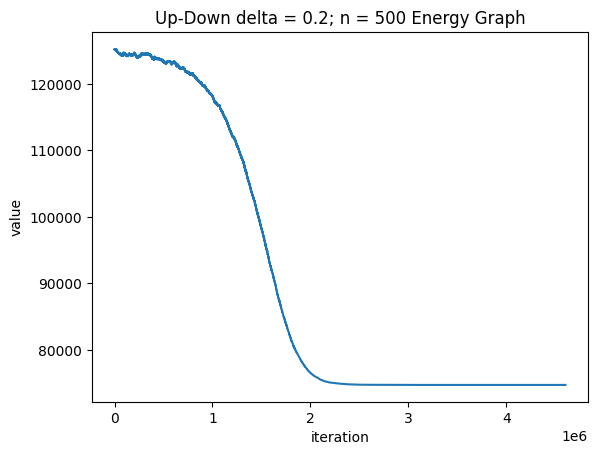

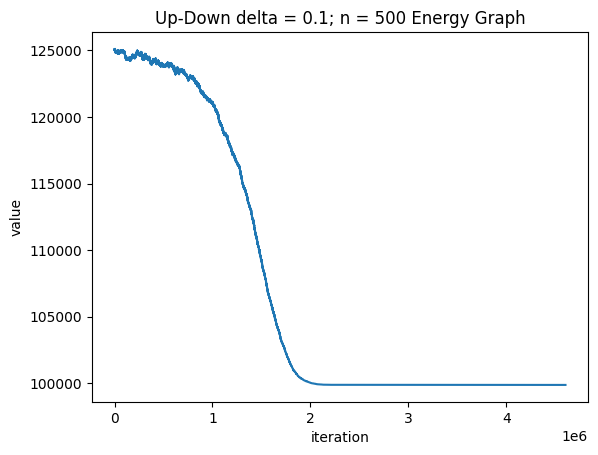

In [39]:
def calculatePointEnergy3(M,point:tuple[int,int]):
    n = len(M)
    add = M[point[0]][point[1]]
    return (add+1) % 2 if point[0] < n//2 else add % 2


def calculateEnergyDiff3(M,point1:tuple[int,int],point2:tuple[int,int]):
    StartEnergy = calculatePointEnergy3(M,point1) + calculatePointEnergy3(M,point2)

    #swap
    M[point1[0]][point1[1]], M[point2[0]][point2[1]] = M[point2[0]][point2[1]],M[point1[0]][point1[1]]

    EndEnergy = calculatePointEnergy3(M,point1) + calculatePointEnergy3(M,point2)

    return EndEnergy - StartEnergy

        
zad2(20,0.4,calculateEnergyDiff3,calculatePointEnergy3,"Up-Down delta = 0.4; n = 20",5e2,3e-4,1e-2)
zad2(20,0.2,calculateEnergyDiff3,calculatePointEnergy3,"Up-Down delta = 0.2; n = 20",5e2,3e-4,1e-2)
zad2(20,0.1,calculateEnergyDiff3,calculatePointEnergy3,"Up-Down delta = 0.1; n = 20",5e2,3e-4,1e-2)
zad2(500,0.4,calculateEnergyDiff3,calculatePointEnergy3,"Up-Down delta = 0.4; n = 500",1e2,3e-6,1e-4)
zad2(500,0.2,calculateEnergyDiff3,calculatePointEnergy3,"Up-Down delta = 0.2; n = 500",1e2,3e-6,1e-4)
zad2(500,0.1,calculateEnergyDiff3,calculatePointEnergy3,"Up-Down delta = 0.1; n = 500",1e2,3e-6,1e-4)

##### Zestawienie wyników

$\delta$ = 0.1

![](lab4zad2/Up-Down%20delta%20=%200.1;%20n%20=%20500Start.png)
![](lab4zad2/Up-Down%20delta%20=%200.1;%20n%20=%20500End.png)

$\delta$ = 0.2

![](lab4zad2/Up-Down%20delta%20=%200.2;%20n%20=%20500Start.png)
![](lab4zad2/Up-Down%20delta%20=%200.2;%20n%20=%20500End.png)

$\delta$ = 0.4

![](lab4zad2/Up-Down%20delta%20=%200.4;%20n%20=%20500Start.png)
![](lab4zad2/Up-Down%20delta%20=%200.4;%20n%20=%20500End.png)


Myśle że najbardziej widoczna jest różnica, aczkolwiek można zauważyć pewne niedokładności, są one związane z szybszym urywaniem kodu. Na planszy 500x500 trafienie akurat w takie 2 pixele które doprowadziły by do zmiany jest bardzo trudne pod koniec, dlatego właśnie zostają niedokładnosci

<hr>

## Zadanie 3. Sudoku

Celem zadania jest pokazanie innego praktycznego zastosowania symowlowanego wyżarzania

### Zczytywanie z pliku + misc

Do rozwiązania sudoku należy je pierwsze zczytać z pliku a następnie przekształcić dane na przyjemną do obróbki formę.

Dla wygody tworzę dwie tablice:
 - jedna będąca sercem wyżarzania, na której funcja będzie operować
 - druga będąca tablicą stałych, z zapisanymi wartościami w odpowiednich miejscach

Dodatkowo stworzyłem prostą funkcje mającą na celu wizualizacji sudoku w przystępniejszy dla oczu sposób

In [43]:
def SudokuReader(path):
    if path is None:
        raise Exception("Nie podano pliku")
    Sudoku = []
    Constants = []
    with open(path, 'r') as file:
        for line in file:
            data = [0 if x == 'x' else int(x) for x in line.strip().split()]
            constant = [x if x > 0 else None for x in data]
            Sudoku.append(data)
            Constants.append(constant)
    return Sudoku, Constants

def printSudoku(Sudoku):
    for line in Sudoku:
        for character in line:
            print(character, end=' ')
        print("")

### Główny kod

wstępnie wypełniam wszystkie puste miejsca liczbami pokolei tak aby wszystkich liczb było tyle samo (po 9)

Jako energie natomiast przyjąłem ilość błędnych komórek. Jeżeli jakaś wartośc na lini horyzontalnej lub wertykalnej albo w danym kwadracie, komórka jest uznawana jako błedna - w innym wypadku komórka jest uznawana jako poprawna


zasada działania podobna jak w poprzednich dwóch zadaniach, dodatkowo natomiast jest dodatkowe kryterium stopu - ilosć błędów równa 0

In [72]:
def SudokuSolver(path,StartingHeat,CoolingRate,HeatLimit):

    def pointError(Sudoku, point:tuple[int,int]):
        value = Sudoku[point[0]][point[1]]

        #horizontal and vertical
        for i in range(9):
            if Sudoku[point[0]][i] == value and i != point[1]:
                return True
            if Sudoku[i][point[1]] == value and i != point[0]:
                return True

        #cell
        cell_x = point[0]//3
        cell_y = point[1]//3
        for i in range(3):
            for j in range(3):
                if Sudoku[cell_x*3 + i][cell_y*3 + j] == value and (cell_x*3 + i != point[0] or cell_y*3+j != point[1]):
                    return True
        return False
             

    def countErrors(Sudoku):
        l = len(Sudoku)
        errors = 0
        for i in range(9):
            for j in range(9):
                if pointError(Sudoku,(i,j)):
                    errors += 1
        return errors
    
    def countErrorChange(Sudoku, point1:tuple[int,int], point2:tuple[int,int]):
        startErrors = countErrors(Sudoku)

        #swap
        Sudoku[point1[0]][point1[1]], Sudoku[point2[0]][point2[1]] = Sudoku[point2[0]][point2[1]],Sudoku[point1[0]][point1[1]]

        endErrors = countErrors(Sudoku)

        return endErrors-startErrors
        
    print("==========", path, "=========")

    Sudoku, constants = SudokuReader(path)
    #naive filling of sudoku:
    count = [0 for _ in range(9)]
    for lines in constants:
        for val in lines:
            if val is None: continue
            count[val-1] += 1
    missingCount = [9-val for val in count]
    current = 0
    for i in range(9):
        for j in range(9):
            if constants[i][j] is None:
                Sudoku[i][j] = current + 1
                missingCount[current] -= 1
                if missingCount[current] <= 0:
                    current += 1

    currEnergy = countErrors(Sudoku)
    Heat = StartingHeat
    coolingRate = CoolingRate
    Energy = []
    for i in range(100000000):
        if Heat <= HeatLimit:
            break
        
        #change values
        x_1,y_1,x_2,y_2 = random.randint(0,8),random.randint(0,8),random.randint(0,8),random.randint(0,8)
        #swaping constants is not allowed
        if constants[x_1][y_1] is not None or constants[x_2][y_2] is not None or Sudoku[x_1][y_1] == Sudoku[x_2][y_2] or (x_1 == x_2 and y_1 == y_2):
            continue
    

        EnergyDiff = countErrorChange(Sudoku,(x_1,y_1),(x_2,y_2))
        

        if( calcAccteptancePropability(EnergyDiff,Heat) > random.random()):
            currEnergy = countErrors(Sudoku)
            
            if currEnergy <= 0:
                break    
        
        else:
            #swap
            Sudoku[x_1][y_1], Sudoku[x_2][y_2] = Sudoku[x_2][y_2], Sudoku[x_1][y_1]

        Energy.append(currEnergy)
        Heat *= 1-coolingRate
    print("\n", "result errors: ", currEnergy,"\n")
    plt.figure()
    plt.title(path + ' Energy Graph')
    plt.xlabel('iteration')
    plt.ylabel('value')
    plt.plot(Energy)
    printSudoku(Sudoku) 
    plt.show()

  

### Wywołania kodu

Zaproponowałem dwa sudoka ze strony sudoku.com jedno z poziomu trudności proste a drugie z największego poziomu trudności

========== sudoku.txt =========

 result errors:  0 

4 3 5 2 6 9 7 8 1 
6 8 2 5 7 1 4 9 3 
1 9 7 8 3 4 5 6 2 
8 2 6 1 9 5 3 4 7 
3 7 4 6 8 2 9 1 5 
9 5 1 7 4 3 6 2 8 
5 1 9 3 2 6 8 7 4 
2 4 8 9 5 7 1 3 6 
7 6 3 4 1 8 2 5 9 


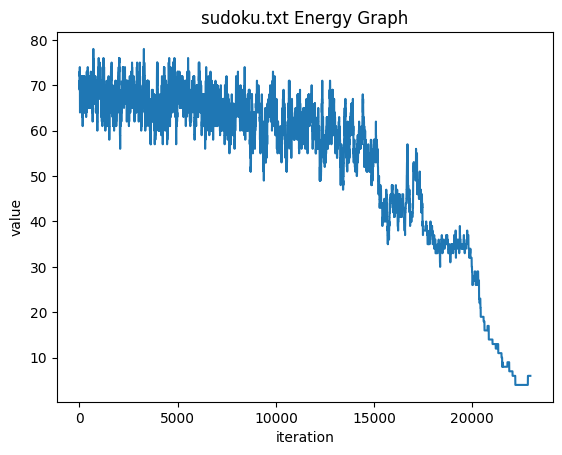

========== sudokuhard.txt =========

 result errors:  8 

4 1 6 7 2 5 9 3 8 
2 5 3 8 9 1 6 4 7 
9 8 7 4 3 6 2 5 1 
6 9 4 5 8 2 1 7 3 
3 1 2 9 4 7 6 8 5 
5 7 8 1 6 3 4 9 2 
8 3 2 6 5 4 7 1 9 
7 6 9 2 1 8 3 5 4 
1 4 5 3 7 9 8 2 6 


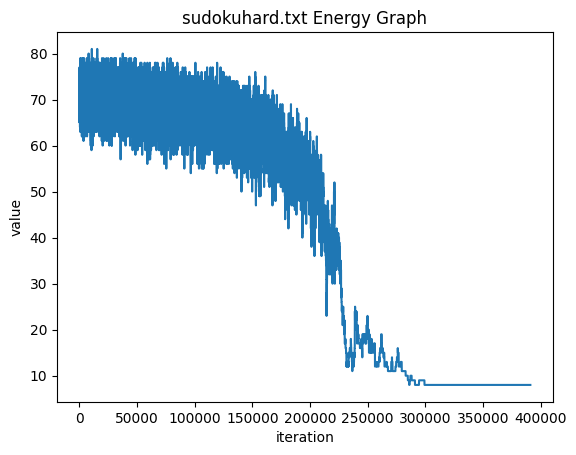

In [73]:
SudokuSolver("sudoku.txt",4,1e-4,1e-2)

SudokuSolver("sudokuhard.txt",5,1e-5,1e-1)


Wyniki dla prostego sudoku są spodziewane - bardzo szybko przy stosunkowo małych parametrach

Niestety natomiast wyniki dla trudnego sudoku są negatywne lecz spodziewane, Ze względu na fakt, iż najtrudniejsze sudoka mają zazwyczaj jedno rozwiązanie, bardzo trudno jest znaleźć akurat tą gałąź która do niego prowadzi.

<hr>

### Zależnośc pustych miejsc od ilości iteracji

Przekształcając powyższy kod na przystępny dla liczenia iteracji

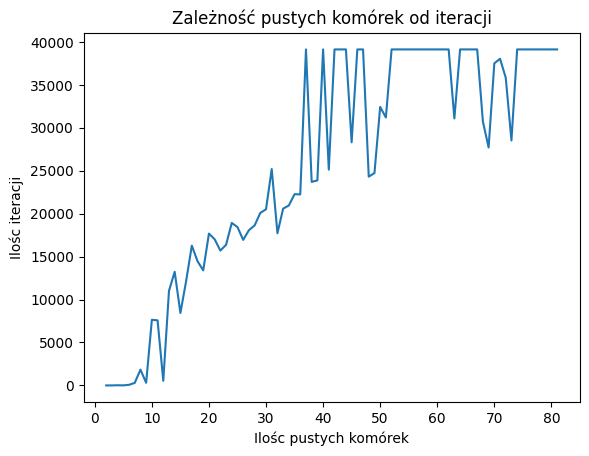

In [76]:
def SudokuSolverIterations(Sudoku,constants,StartingHeat,CoolingRate,HeatLimit):

    def pointError(Sudoku, point:tuple[int,int]):
        value = Sudoku[point[0]][point[1]]

        #horizontal and vertical
        for i in range(9):
            if Sudoku[point[0]][i] == value and i != point[1]:
                return True
            if Sudoku[i][point[1]] == value and i != point[0]:
                return True

        #cell
        cell_x = point[0]//3
        cell_y = point[1]//3
        for i in range(3):
            for j in range(3):
                if Sudoku[cell_x*3 + i][cell_y*3 + j] == value and (cell_x*3 + i != point[0] or cell_y*3+j != point[1]):
                    return True
        return False
             

    def countErrors(Sudoku):
        l = len(Sudoku)
        errors = 0
        for i in range(9):
            for j in range(9):
                if pointError(Sudoku,(i,j)):
                    errors += 1
        return errors
    
    def countErrorChange(Sudoku, point1:tuple[int,int], point2:tuple[int,int]):
        startErrors = countErrors(Sudoku)

        #swap
        Sudoku[point1[0]][point1[1]], Sudoku[point2[0]][point2[1]] = Sudoku[point2[0]][point2[1]],Sudoku[point1[0]][point1[1]]

        endErrors = countErrors(Sudoku)

        return endErrors-startErrors
        
    #naive filling of sudoku:
    count = [0 for _ in range(9)]
    for lines in constants:
        for val in lines:
            if val is None: continue
            count[val-1] += 1
    missingCount = [9-val for val in count]
    current = 0
    while missingCount[current] == 0:
        current += 1
    for i in range(9):
        for j in range(9):
            if constants[i][j] is None:
                Sudoku[i][j] = current + 1
                missingCount[current] -= 1
                while missingCount[current] == 0:
                    current += 1
                    if current >= 8:
                        break


    currEnergy = countErrors(Sudoku)
    Heat = StartingHeat
    coolingRate = CoolingRate
    iterations = 0
    while iterations < 1_000_000 and Heat > HeatLimit and currEnergy > 0:
        
        #change values
        x_1,y_1,x_2,y_2 = random.randint(0,8),random.randint(0,8),random.randint(0,8),random.randint(0,8)
        #swaping constants is not allowed
        if constants[x_1][y_1] is not None or constants[x_2][y_2] is not None or Sudoku[x_1][y_1] == Sudoku[x_2][y_2] or (x_1 == x_2 and y_1 == y_2):
            continue
    

        EnergyDiff = countErrorChange(Sudoku,(x_1,y_1),(x_2,y_2))
        

        if( calcAccteptancePropability(EnergyDiff,Heat) > random.random()):
            currEnergy = countErrors(Sudoku)
              
        
        else:
            #swap
            Sudoku[x_1][y_1], Sudoku[x_2][y_2] = Sudoku[x_2][y_2], Sudoku[x_1][y_1]
        iterations += 1
        Heat *= 1-coolingRate
    
    return iterations

def SudokuIterationCounter(path):
    def clearRandom(amount):
        nonlocal Sudoku, constants
        T = [i for i in range(81)]
        random.shuffle(T)
        for i in range(amount):
            Sudoku[T[i] // 9][T[i] % 9] = 0
            constants[T[i] // 9][T[i] % 9] = None

    SudokuBase, constantsBase = SudokuReader(path)
    iterationsResult = []
    X = []
    for i in range(2,82):
        Sudoku = deepcopy(SudokuBase)
        constants = deepcopy(constantsBase)
        clearRandom(i)
        iterationsResult.append(SudokuSolverIterations(Sudoku,constants,5,1e-4,1e-1))
        X.append(i)

    plt.figure()
    plt.xlabel("Ilośc pustych komórek")
    plt.ylabel("Ilośc iteracji")
    plt.title("Zależność pustych komórek od iteracji")
    plt.plot(X,iterationsResult)

SudokuIterationCounter("solvedsudoku.txt")

Jak widać, wraz z zwiększeniem pustych komórek, ilośc iteracji wzrasta. Dodatkowo widać że po ponad połowie większość iteracji wpada w minima lokalne, które nie są rozwiązaniami. Dodatkowo można zauważyć że wśród tych iteracji, które nie wpadły w minimum lokalne, gdyby nakreślić ich krzywą przypominałaby funkcje logarytmiczą. Jest to niestety tylko obserwacja i nie jestem w stanie wywnioskować żadnych wniosków na tej podstawie (równie dobrze, może to być zwykły przypadek)

<hr>

## Podsumowanie

Symuolowane wyżażanie jest to bardzo potężna technika znajdowania minimów w funkcjach stochastycznych. Zdecydowanie może być przydatna także w wielu problemach praktycznych w których nie chodzi nam o dokładne rozwiązanie ale o przybliżone. To laboratorium było, o ile czasochłonne, to za to bardzo ciekawe i przyjemne do robienia. Poszukiwanie sposobów optymalizacji kodu takich jak, wykonywanie zadań in situ lub sprawdzanie tylko części która się zmienia zamiast wyliczania całej energii. Szczęśliwie w każdym zadaniu udało się uzyskać wyniki przewidywane.

<hr>

## Bibliografia

[1] - https://pl.wikipedia.org/wiki/Symulowane_wyżarzanie
[2] - https://en.wikipedia.org/wiki/Gradient_descent
